In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
import warnings
warnings.filterwarnings("ignore")
from yellowbrick.regressor import PredictionError
from sklearn.neural_network import MLPRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
from scikeras.wrappers import KerasRegressor
import numpy as np
import keras_tuner
import keras
from keras import layers
import os
from keras.callbacks import EarlyStopping
from keras.losses import mean_squared_error as mse_loss

2024-06-18 11:27:29.691554: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-18 11:27:29.691886: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-18 11:27:29.695497: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-18 11:27:29.812625: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-18 11:27:31.540471: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

In [24]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, median_absolute_error, max_error
import kerastuner as kt

class DistrictAnalysis_Fine_tuned:
    
    def __init__(self, csv_file, year):
        self.df_main = pd.read_csv(csv_file)
        self.year = year
        self.plot_folder = "/home/ravi/myfolder/project/artpark/dengue data/plots"
        os.makedirs(self.plot_folder, exist_ok=True) 
        
    def pop_mean(self):
        self.df_main = self.df_main[self.df_main['Year'].isin([2017,2018,2019,2022])]
        #self.df_main ['Case_Count'] = self.df_main ['Case_Count'] / (self.df_main ['Population'] / 1000000)
        return self.df_main

    def process_district_data(self, district_name):
        df_c = self.df_main.loc[self.df_main['District'] == district_name]
        df_c = df_c.dropna().reset_index(drop=True)
        return df_c
    
    def build_and_predict_model(self, x_train, y_train, x_test, y_test, district_name):
        def build_model(hp):
            model = keras.Sequential()
            model.add(layers.Dense(64, activation="relu", input_shape=(x_train.shape[1],)))
            for i in range(hp.Int("num_layers", 1, 1)):
                model.add(
                    layers.Dense(
                        units=hp.Int(f"units_{i}", min_value=16, max_value=64, step=16),
                        activation=hp.Choice("activation", ["relu", "leaky_relu"]),
                    )
                )
    
            if hp.Boolean("dropout"):
                model.add(layers.Dropout(rate=0.25))
    
            model.add(layers.Dense(1, activation="linear"))
    
            learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
            model.compile(
                optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                loss=mse_loss,  # Specify the loss function
                metrics=["mse"],
            )
            return model
    
        tuner = keras_tuner.RandomSearch(
            hypermodel=build_model,
            objective="mse",
            max_trials=5,
            executions_per_trial=5,
            overwrite=True,
        )
    
        tuner.search(x_train, y_train, epochs=10, validation_split=0.2)
        print("Search completed!")
    
        # Get the best model
        best_model = tuner.get_best_models(num_models=1)[0]
    
        # Save the best model
        district_model_folder = os.path.join(self.plot_folder, district_name, 'Neural_network')
        os.makedirs(district_model_folder, exist_ok=True)
        best_model.save(os.path.join(district_model_folder, f'{self.year}best_model.h5'))
        print("Best Model saved successfully!")
    
        # Print summary of the best model
        print("Best Model Summary:")
        best_model.summary()
    
        # Fit the best model
        early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=0, mode='min', restore_best_weights=True)
        history = best_model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0, validation_split=0.2, callbacks=[early_stopping])
    
        # Use the saved model for prediction
        saved_model_path = os.path.join(district_model_folder, f'{self.year}best_model.h5')
        saved_model = keras.models.load_model(saved_model_path, custom_objects={'mse': mse_loss})
        y_pred = saved_model.predict(x_test).reshape(-1)
        mse = mean_squared_error(y_test, y_pred)
        rmse = mse ** 0.5
    
        return y_pred, rmse, best_model, history


    def plot_prediction(self, district_name, rmse, y_pred, y_test):
        mse = mean_squared_error(y_test, y_pred)

        plt.figure(figsize=(10, 6))
        plt.bar(range(len(y_test)), y_test, color='blue', label='Actual')
        plt.plot(range(len(y_pred)), y_pred, color='red', marker='o', linestyle='-',
                 linewidth=2, markersize=6, label='Predicted')
        plt.xlabel('Index')
        plt.ylabel('Values')
        plt.title(f'Actual vs Predicted Values for {district_name}')
        plt.legend(loc='upper left')
        plt.grid(True)
        plt.text(0.02, 0.88, f'RMSE: {rmse:.2f}', transform=plt.gca().transAxes, color='red',
                 weight='bold', verticalalignment='top', fontsize=12)

        district_plot_folder = os.path.join(self.plot_folder, district_name, 'Neural_network')
        os.makedirs(district_plot_folder, exist_ok=True)  # Create the folder if it doesn't exist
        plt.savefig(os.path.join(district_plot_folder, f'{self.year}prediction_plot.png'))

    def plot_loss(self, history, district_name):
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(f'Tuned Model loss - District: {district_name}')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        district_plot_folder = os.path.join(self.plot_folder, district_name, 'Neural_network')
        os.makedirs(district_plot_folder, exist_ok=True)  # Create the folder if it doesn't exist
        plt.savefig(os.path.join(district_plot_folder, f'{self.year}loss_plot.png'))

        plt.close()

    def calculate_error_metrics(self, y_test, y_pred):
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        explained_variance = explained_variance_score(y_test, y_pred)
        median_ae = median_absolute_error(y_test, y_pred)
        max_err = max_error(y_test, y_pred)
        error_metrics = pd.DataFrame({
            'Error Metric': ['Mean Squared Error (MSE)', 'Mean Absolute Error (MAE)', 
                             'R-squared (R2)', 'Explained Variance Score', 
                             'Median Absolute Error', 'Maximum Error'],
            'Value': [mse, mae, r2, explained_variance, median_ae, max_err]
        })
        return error_metrics

    def split_train_test(self, df):
        train_data = df[~(df['Year'].isin([self.year]))]
        #train_data = train_data[train_data['Record_Week'] < 46]

        test_data = df[df['Year'] == self.year]
        #test_data = test_data[test_data['Record_Week'] < 46]

        # Extracting features (X) and target variable (Y) for train and test sets
        x_train = train_data[["2m_Temperature", "2m_Dewpoint_Temperature", "Total_Precipitation"]]
        y_train = train_data["Case_Count"]

        x_test = test_data[["2m_Temperature", "2m_Dewpoint_Temperature", "Total_Precipitation"]]
        y_test = test_data["Case_Count"]

        # Standardize features
        scaler = StandardScaler()
        x_train_scaled = scaler.fit_transform(x_train)
        x_test_scaled = scaler.transform(x_test)

        return x_train_scaled, x_test_scaled, y_train, y_test
    
    def analyze_districts(self):
        unique_districts = self.df_main['District'].unique()
        all_district_data = []
        for district_name in unique_districts:
            print(f"Analyzing District: {district_name}")
            district_data = self.process_district_data(district_name)
            x_train, x_test, y_train, y_test = self.split_train_test(district_data)
            
            y_pred_svr, rmse_svr, best_model, history = self.build_and_predict_model(x_train, y_train, x_test, y_test,district_name)
            performance = "Good" if rmse_svr < 2 else "Bad"
    
            district_data = {
                "district": district_name,
                f"{self.year}_rmse": rmse_svr,
                f"{self.year}_performance": performance
            }
    
            all_district_data.append(district_data)
            final_df = pd.DataFrame(all_district_data)
            
            self.plot_prediction(district_name, rmse_svr, y_pred_svr, y_test)
            self.plot_loss(history, district_name)
            print("=" * 100)
        return final_df


Trial 5 Complete [00h 02m 47s]
mse: 14.916347885131836

Best mse So Far: 14.916347885131836
Total elapsed time: 00h 13m 52s
Search completed!


Best Model saved successfully!
Best Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 48)             │         3,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,425 (13.38 KB)

 Trainable params: 3,425 (13.38 KB)

 Non-trainable params: 0 (0.00 B)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


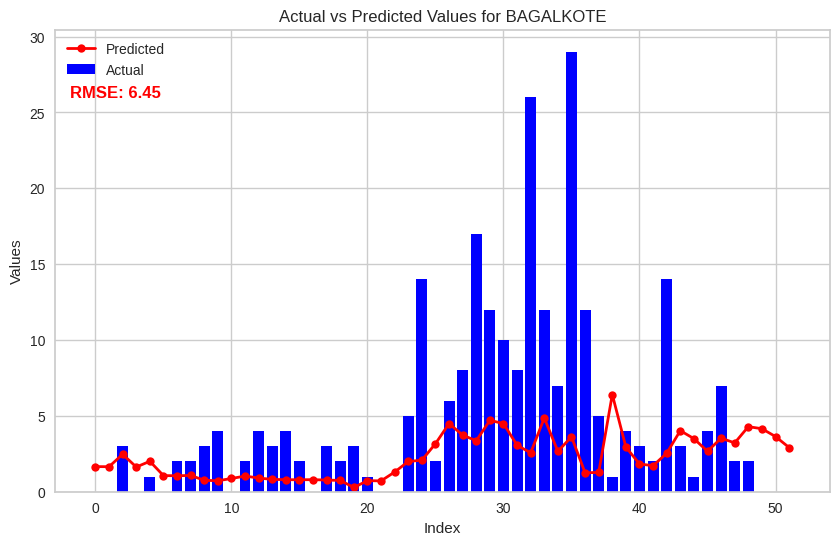

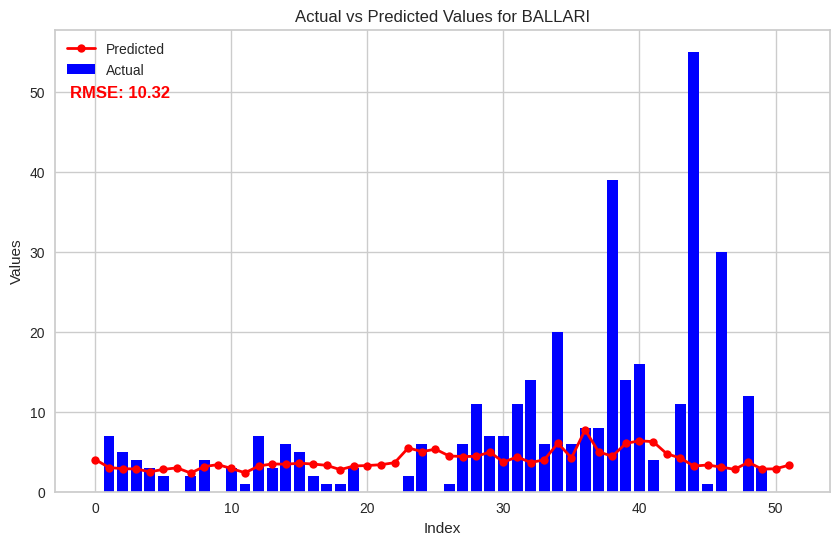

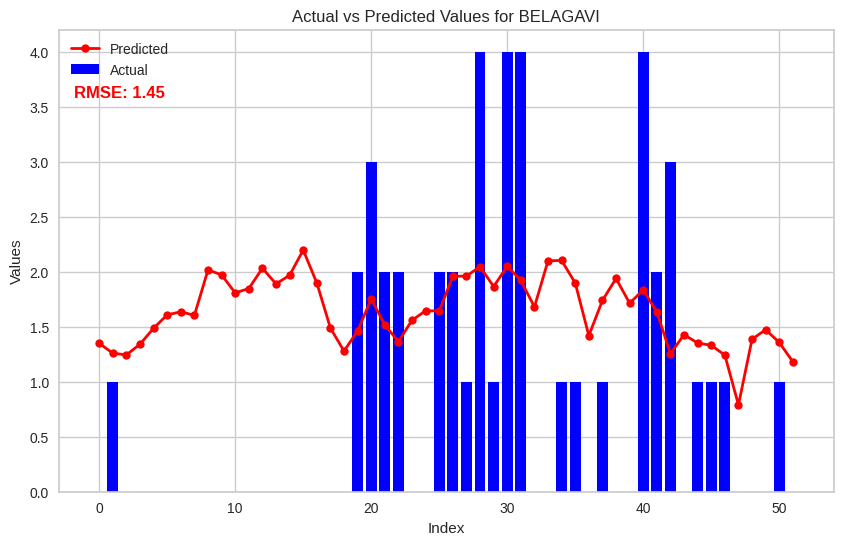

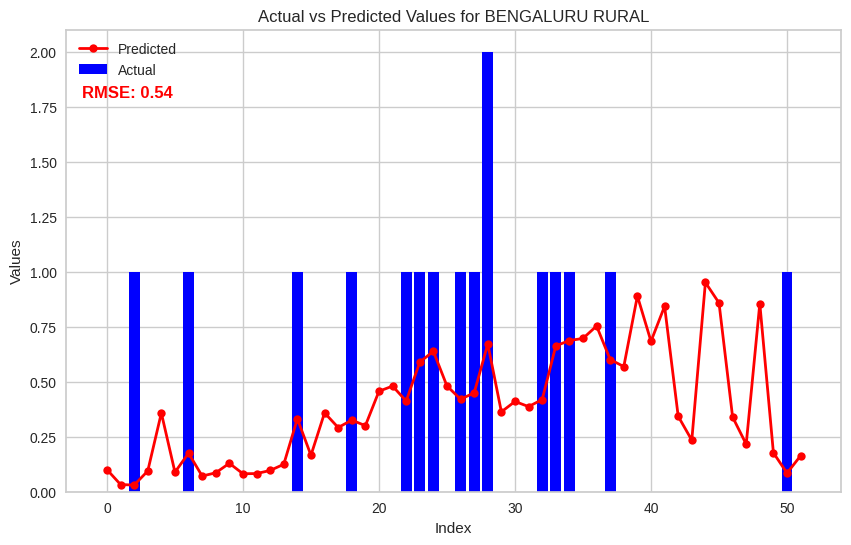

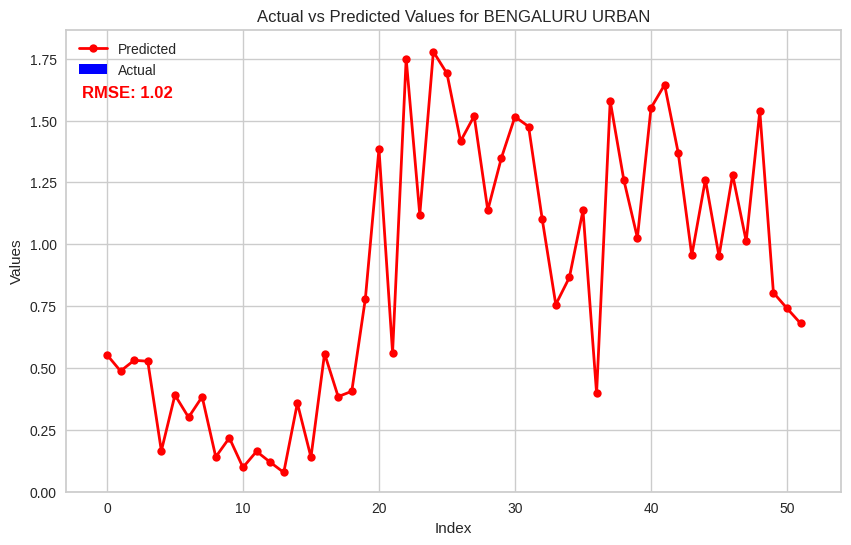

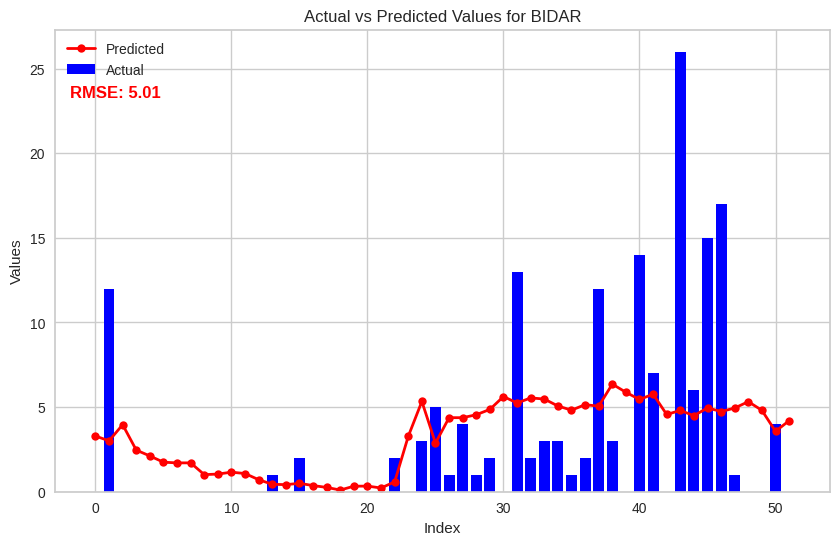

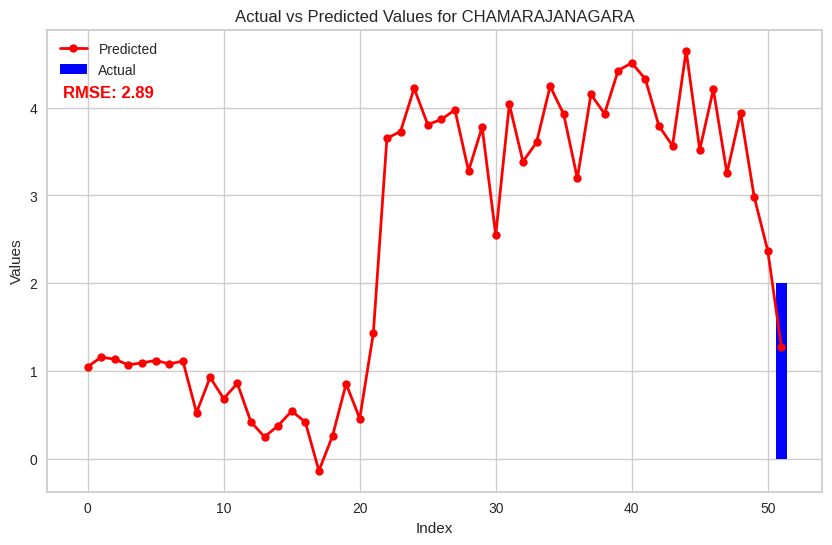

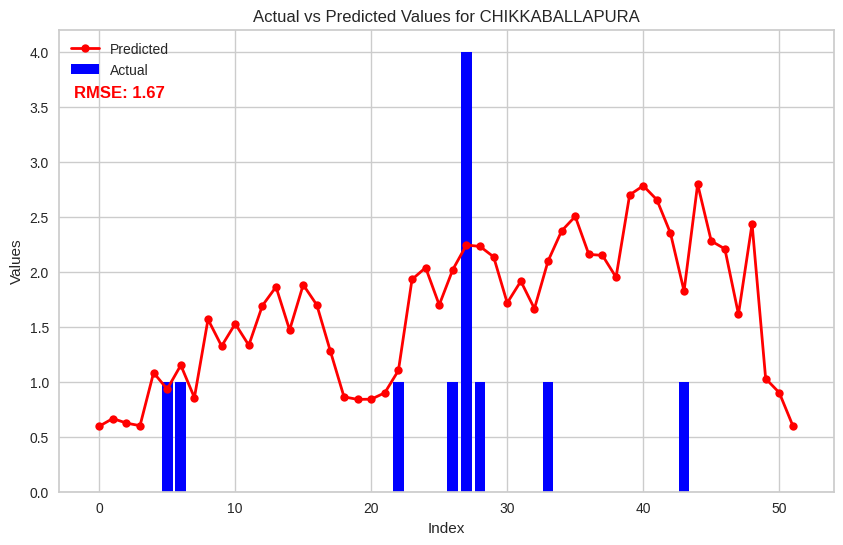

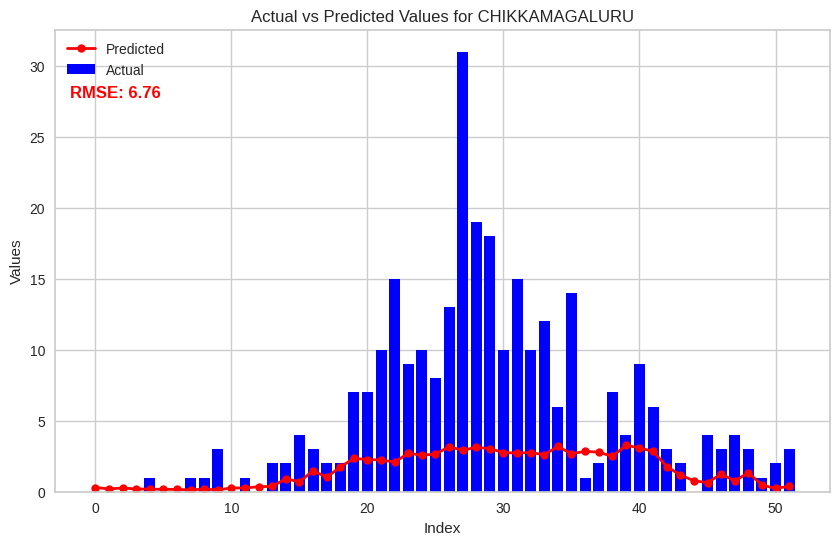

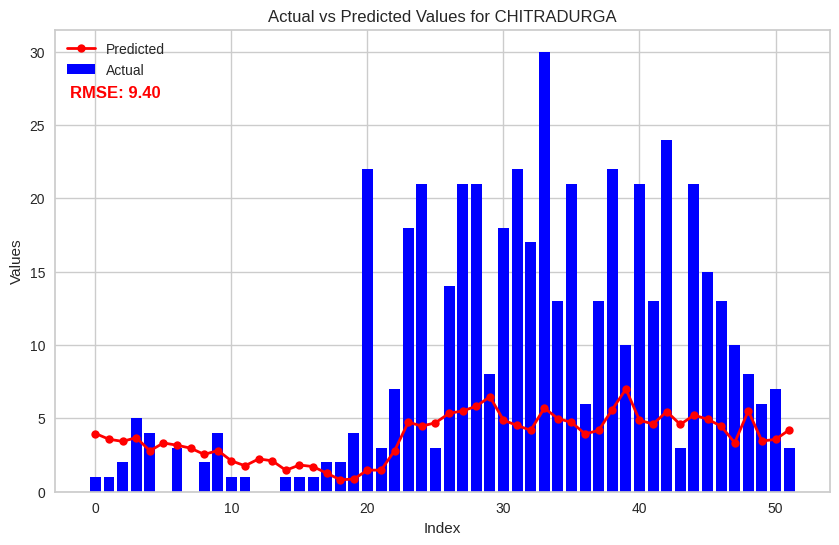

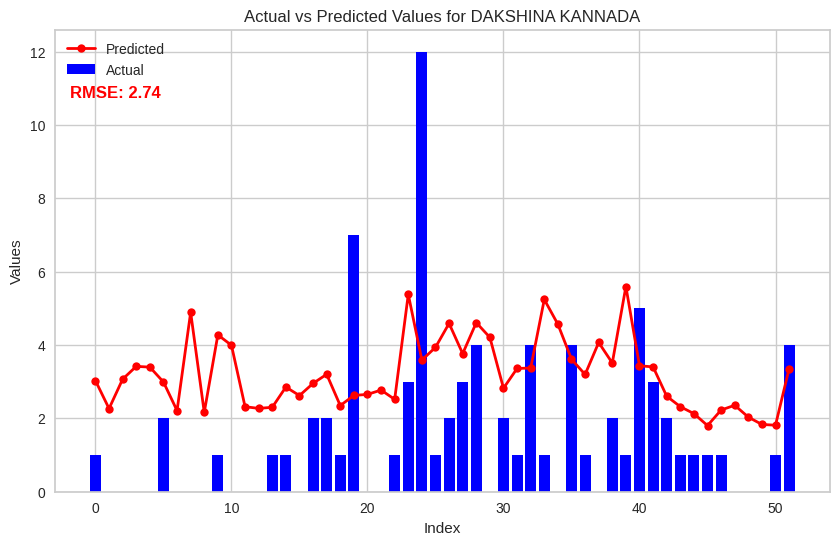

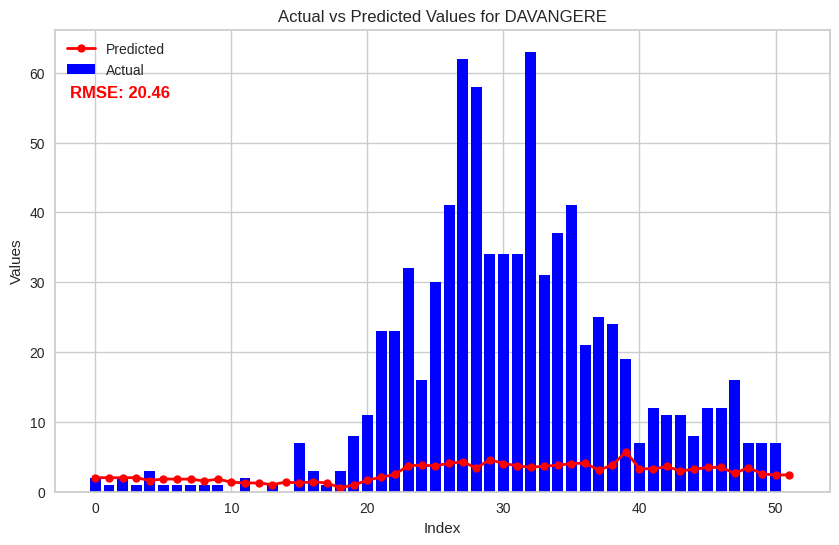

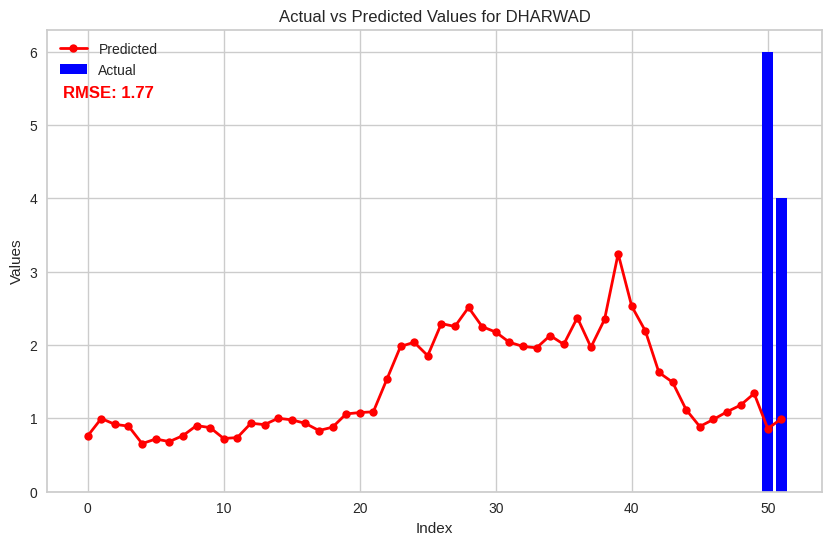

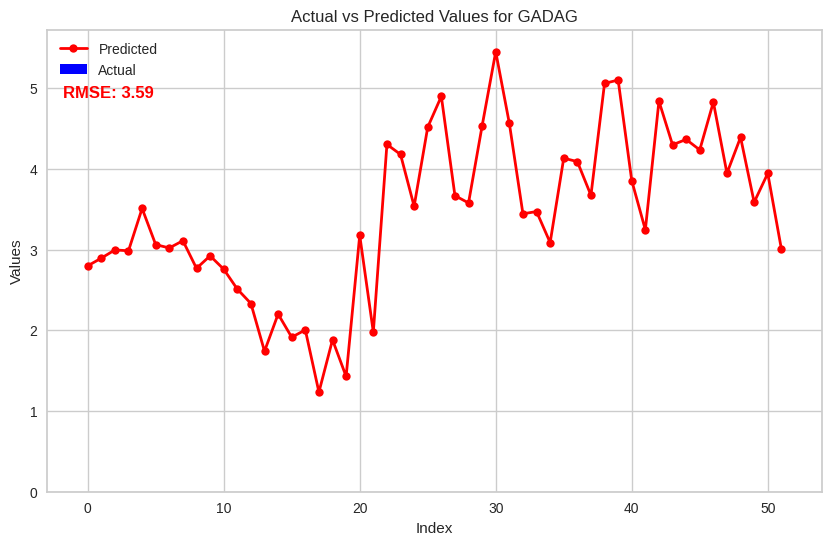

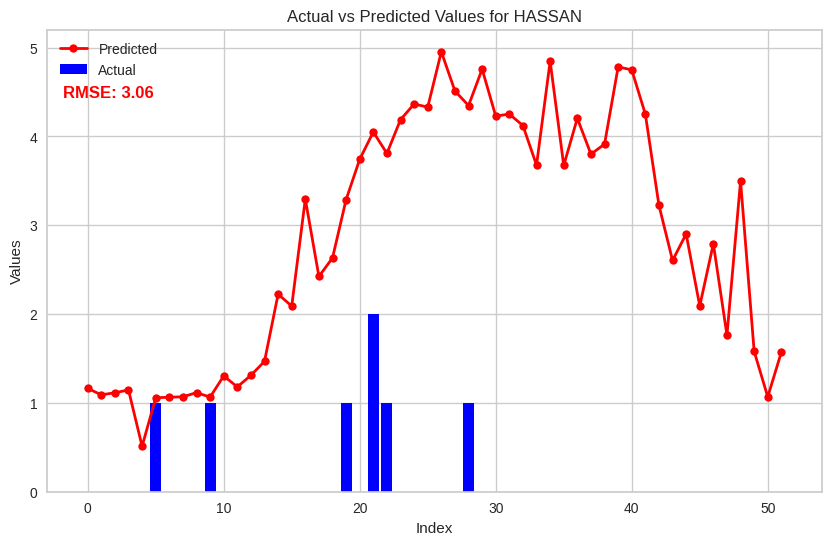

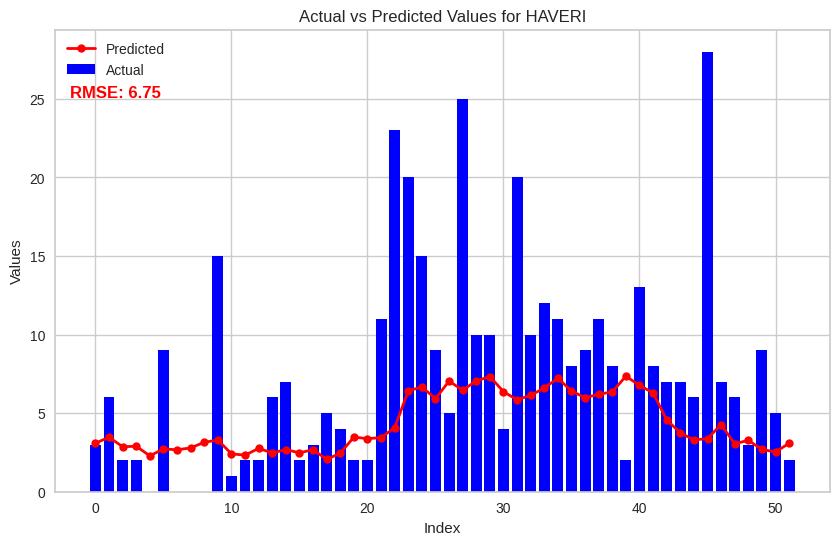

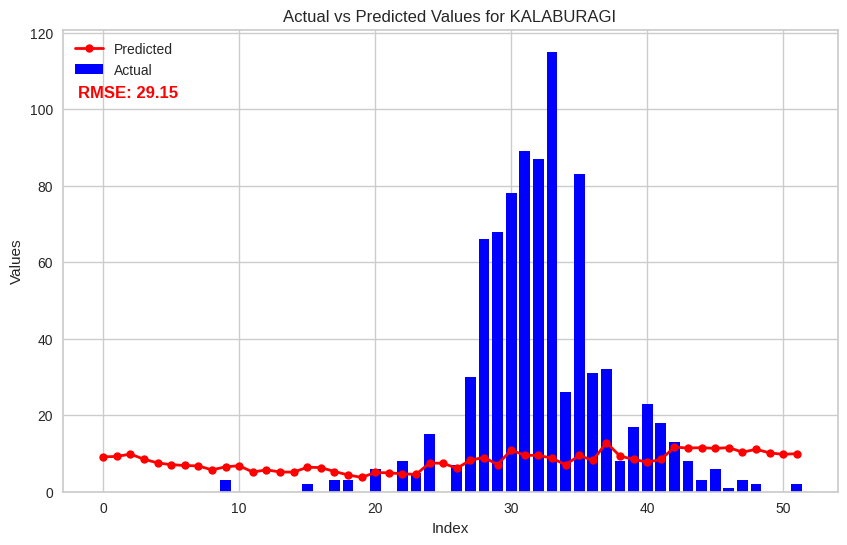

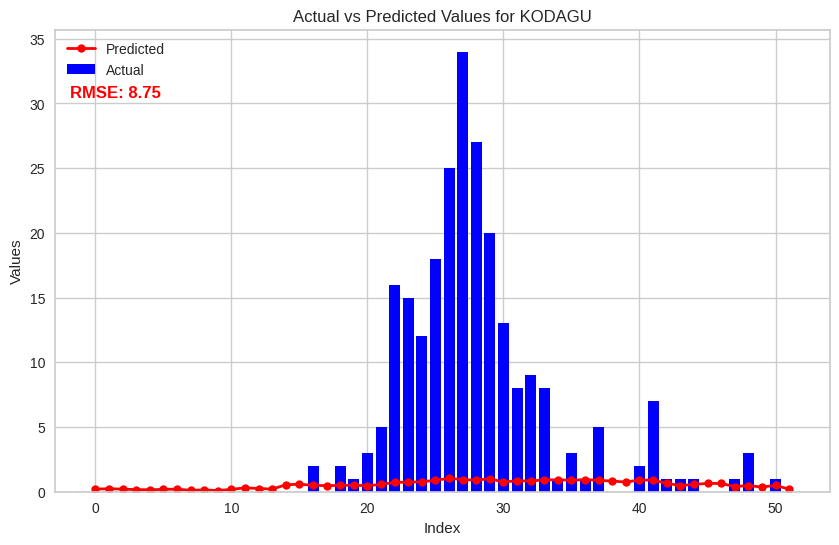

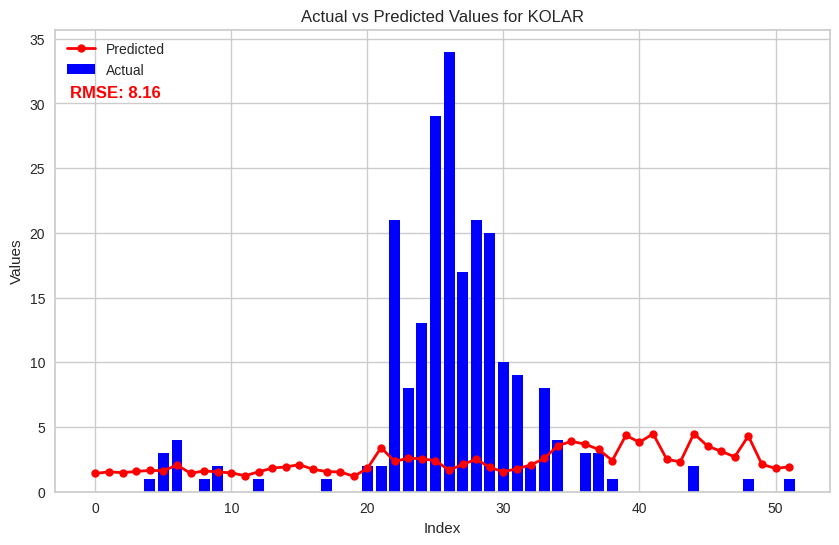

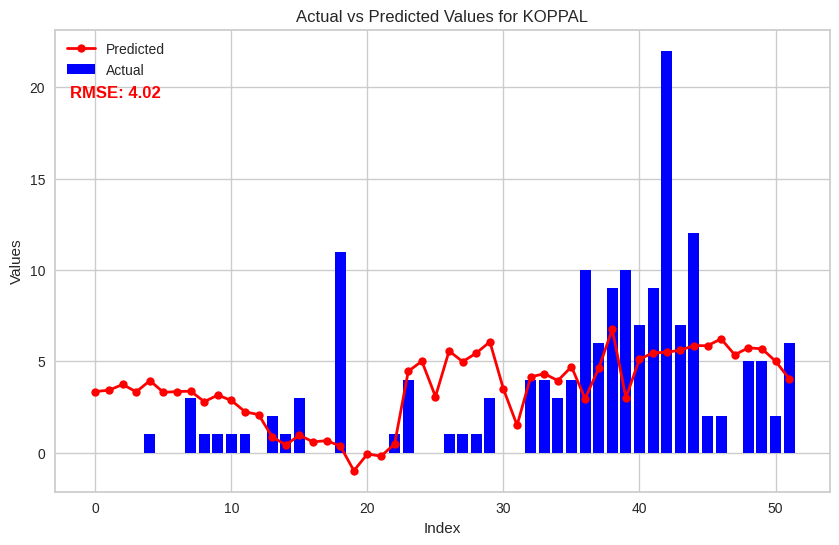

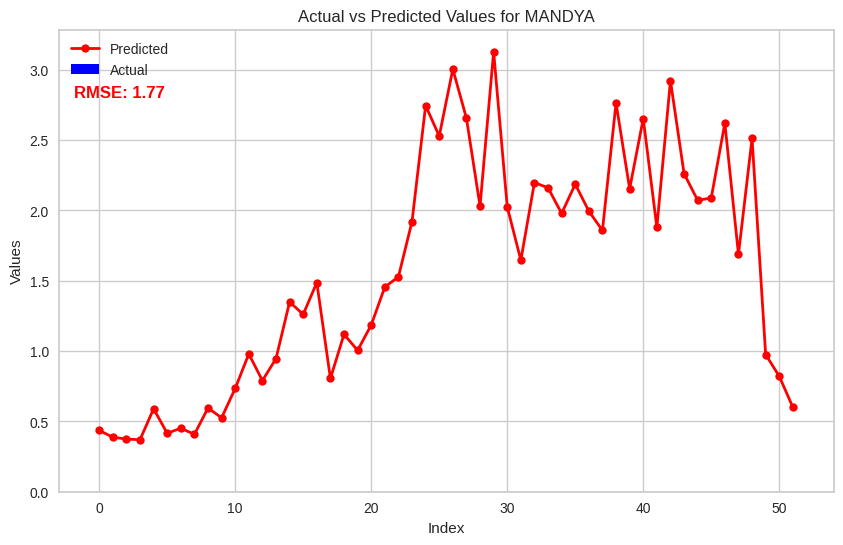

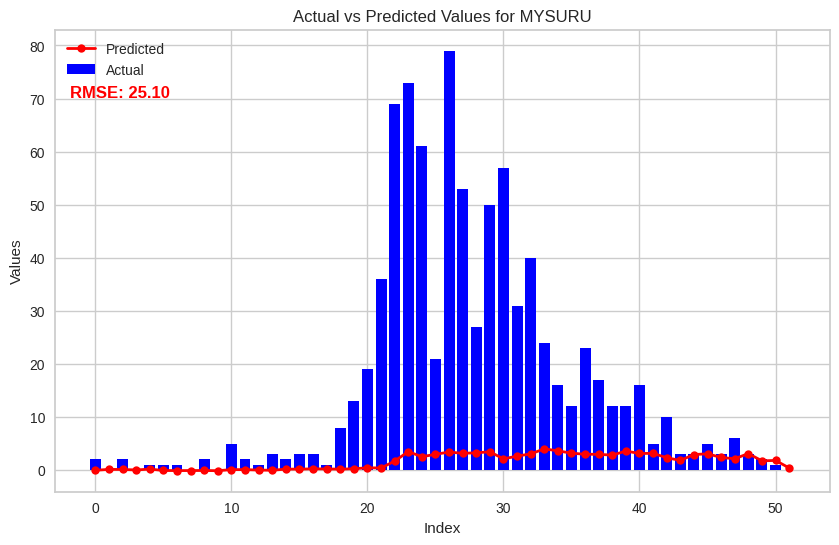

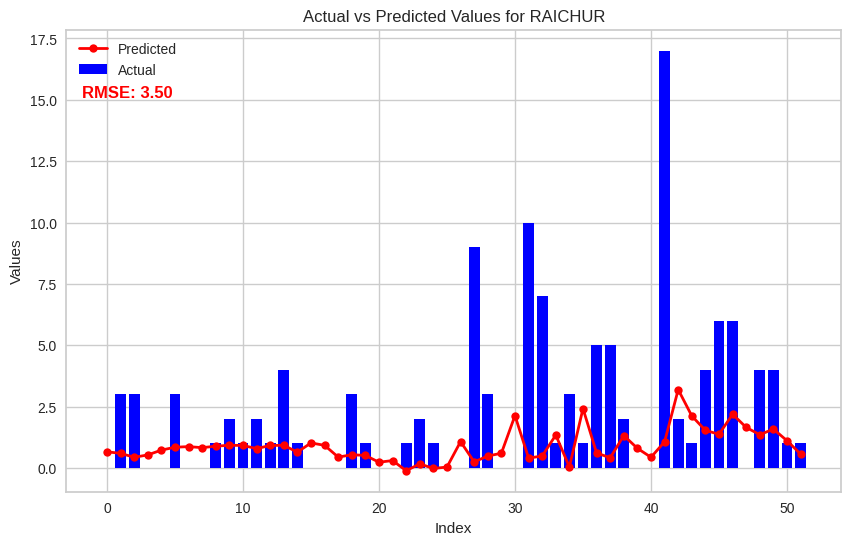

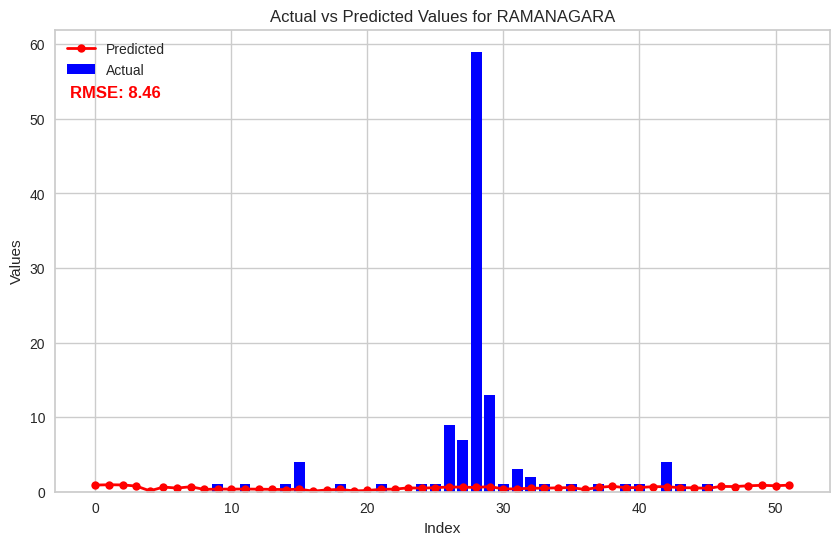

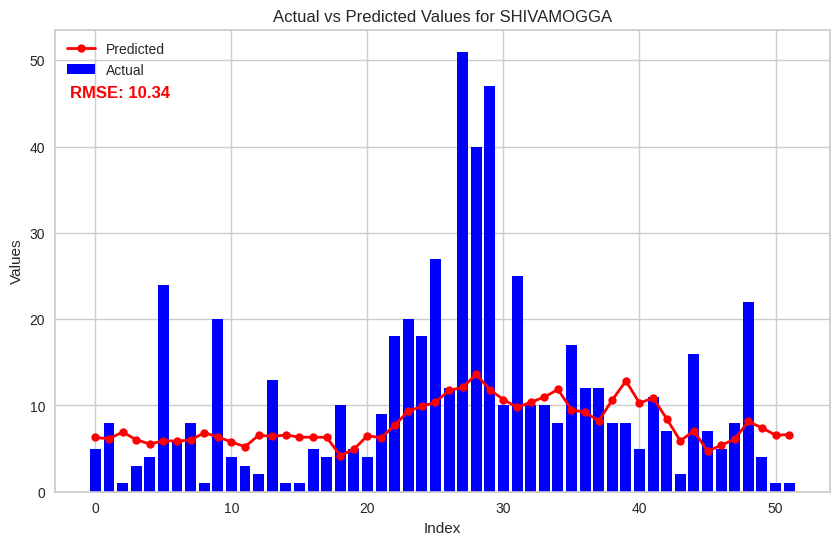

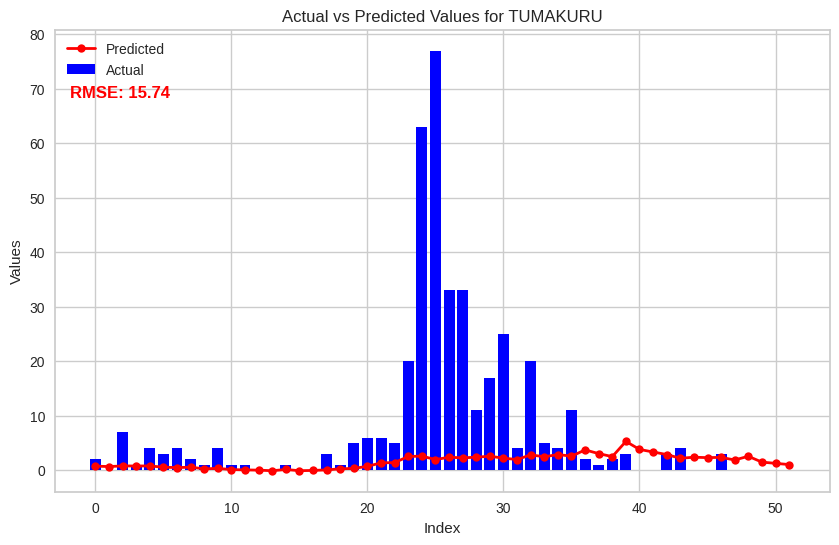

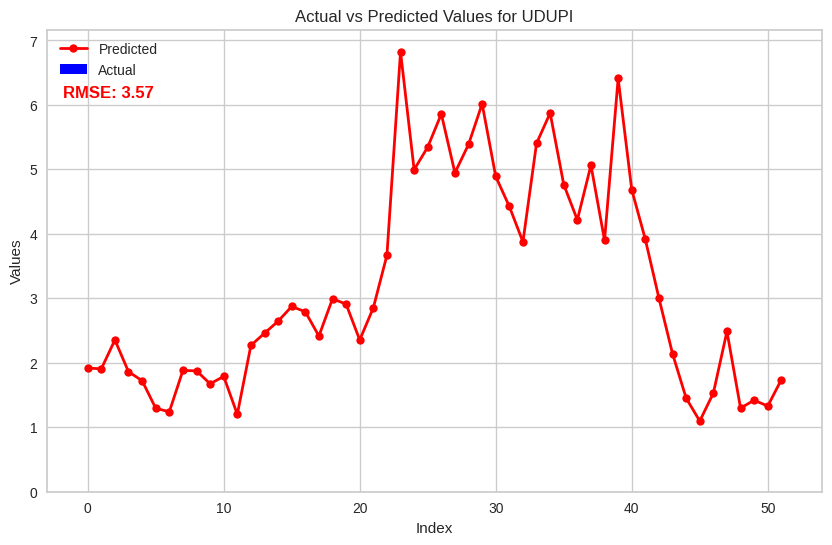

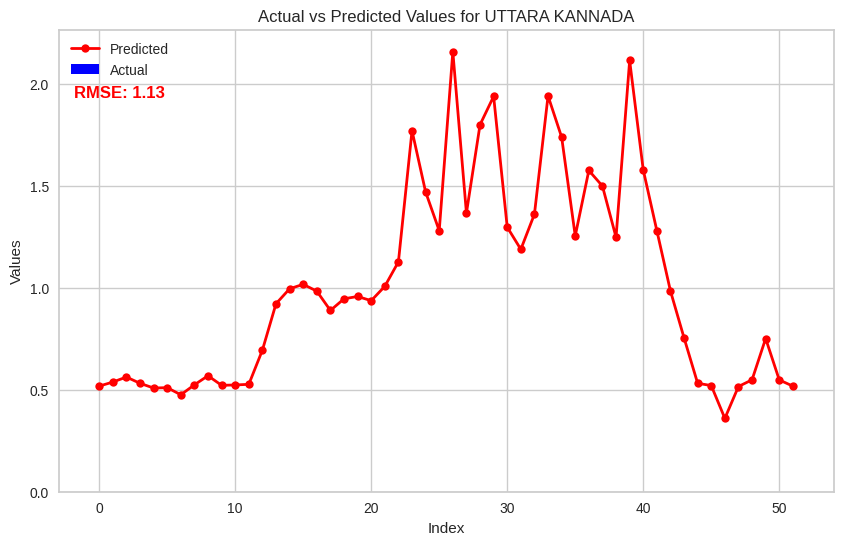

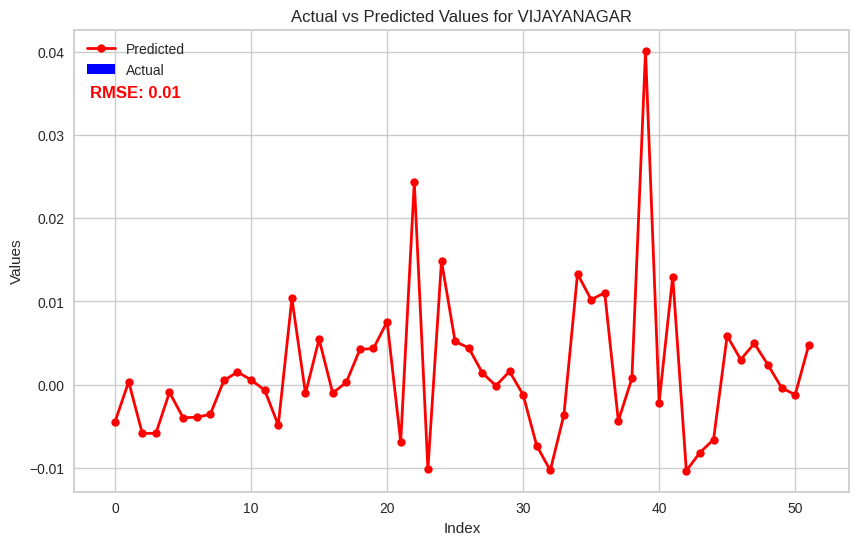

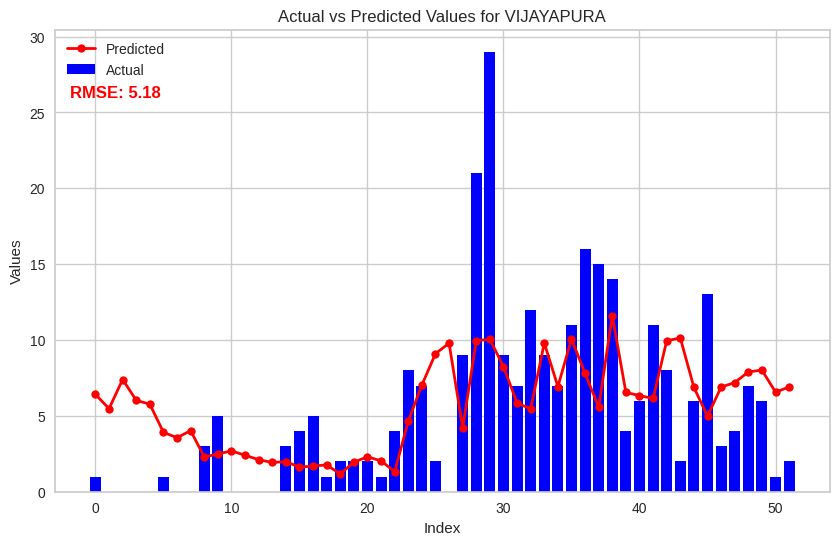

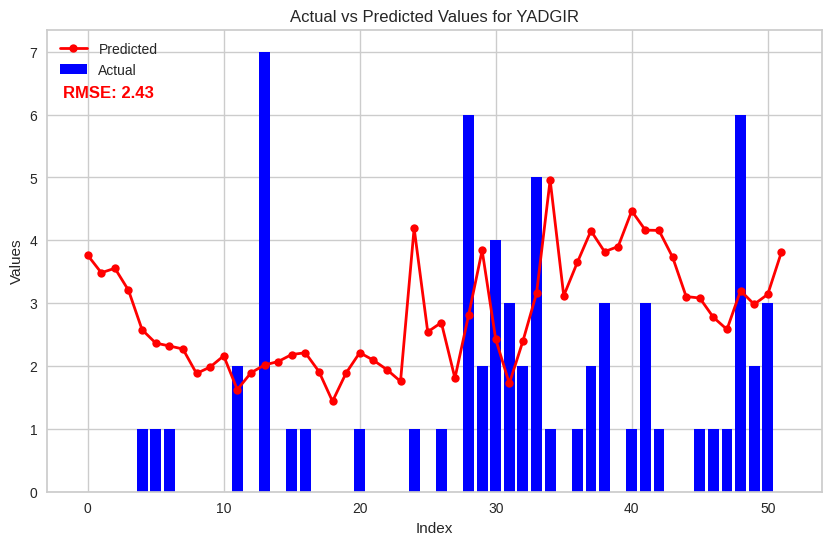

In [25]:
district_analysis_ = DistrictAnalysis_Fine_tuned("Karnataka_weather1980to2022.csv",2017)
df_2017 = district_analysis_.analyze_districts()


Trial 5 Complete [00h 03m 11s]
mse: 23.26344566345215

Best mse So Far: 18.395988082885744
Total elapsed time: 00h 15m 51s
Search completed!


Best Model saved successfully!
Best Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,313 (5.13 KB)

 Trainable params: 1,313 (5.13 KB)

 Non-trainable params: 0 (0.00 B)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


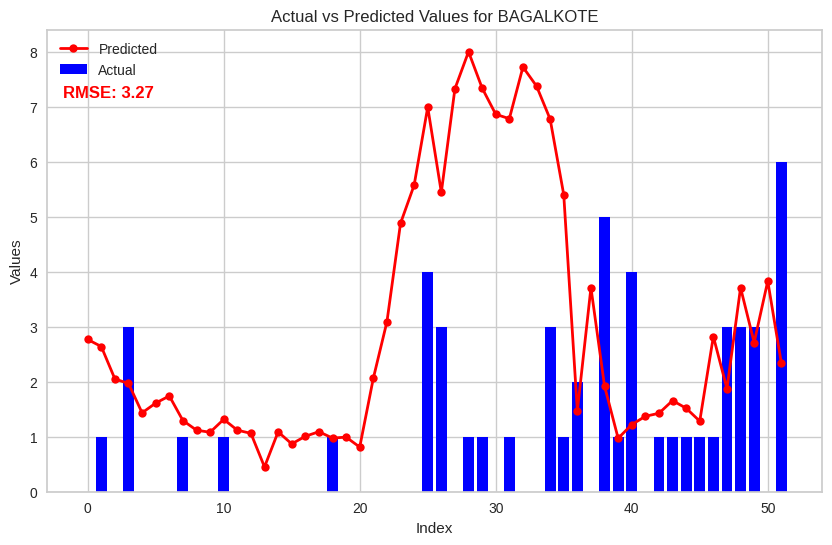

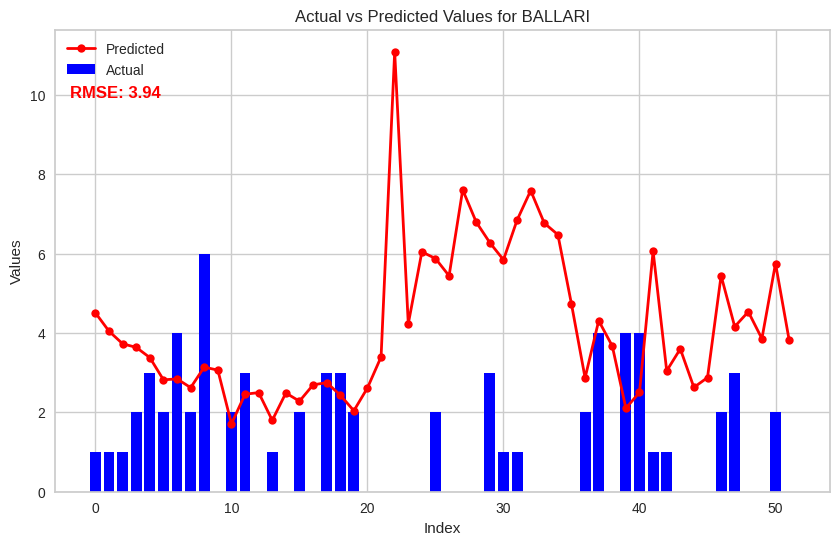

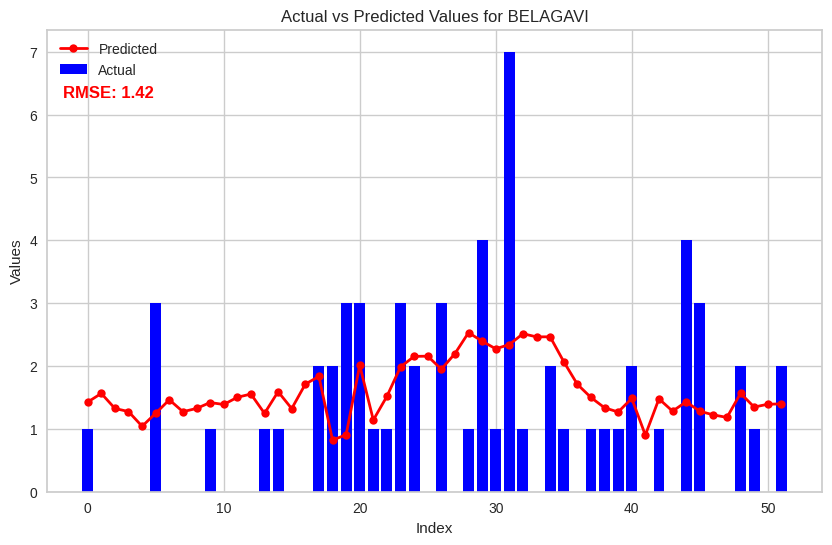

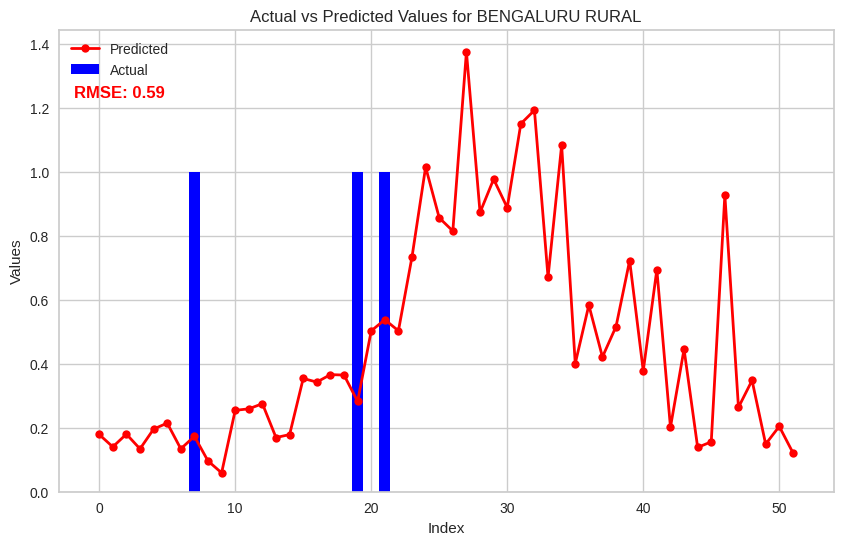

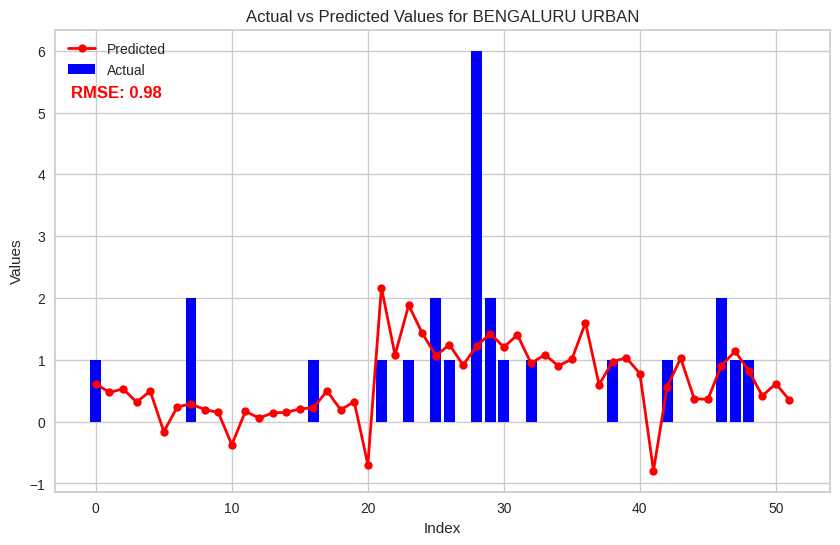

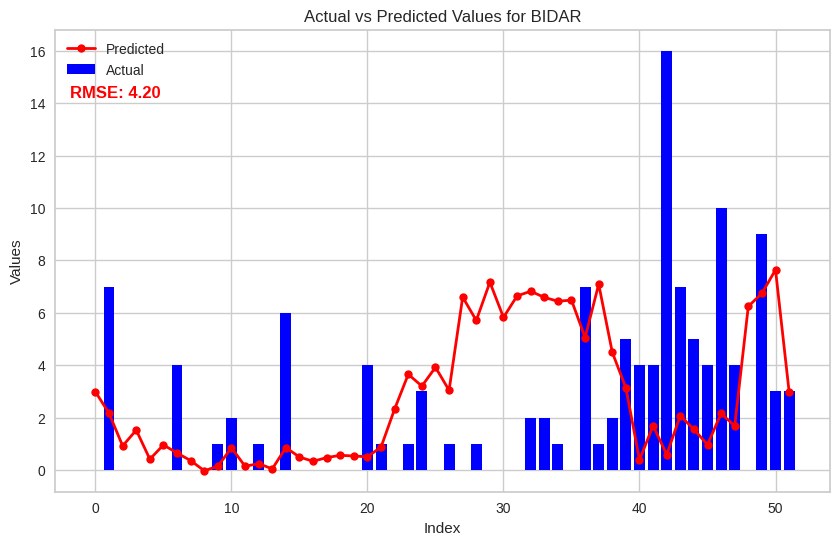

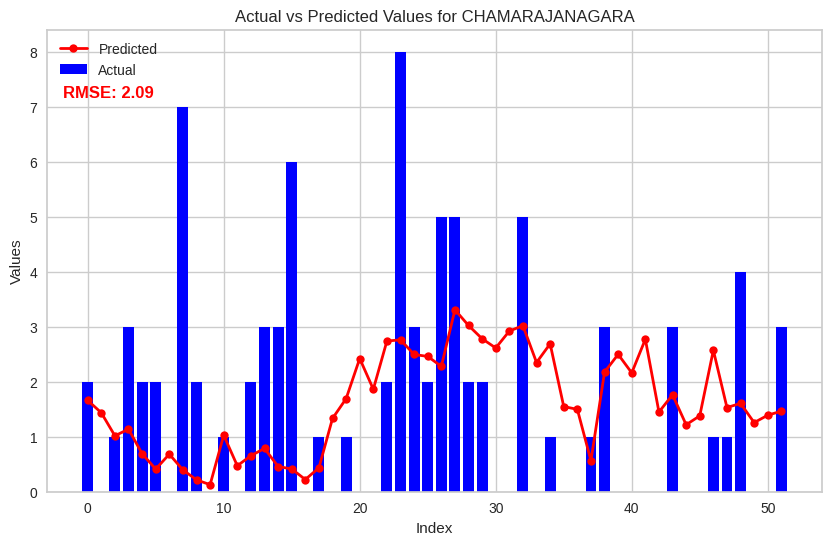

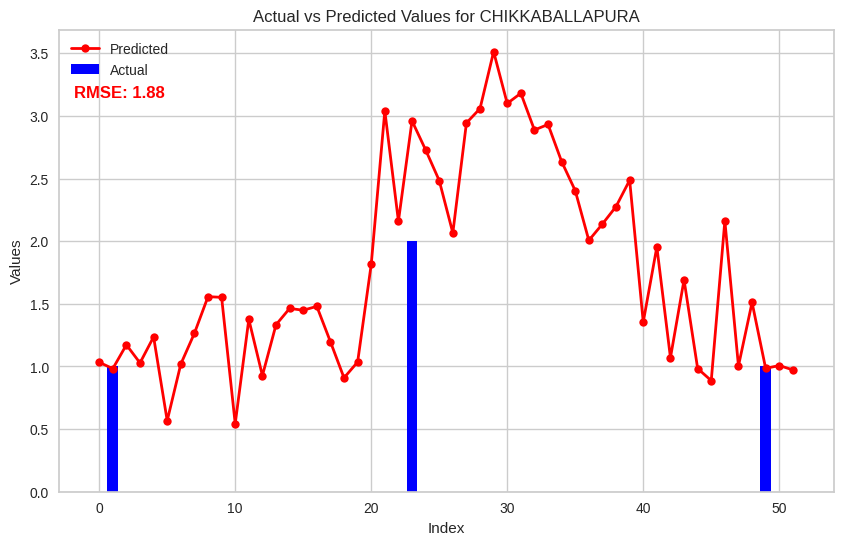

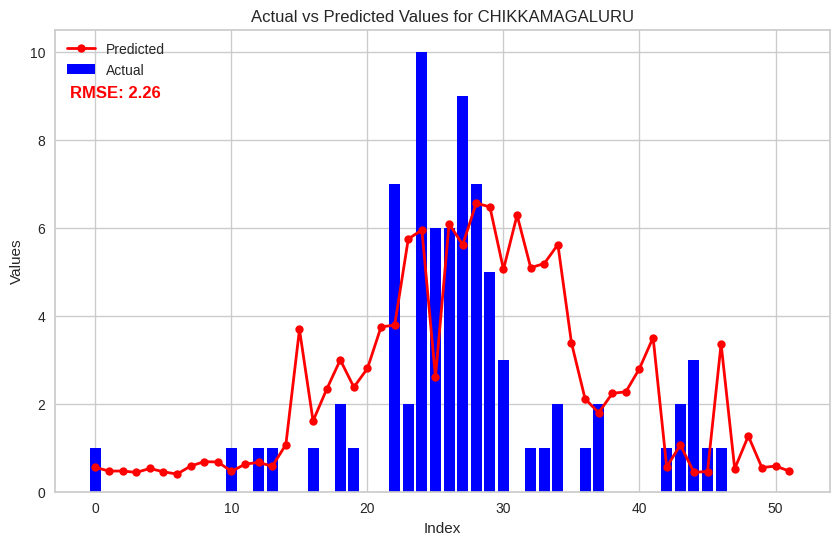

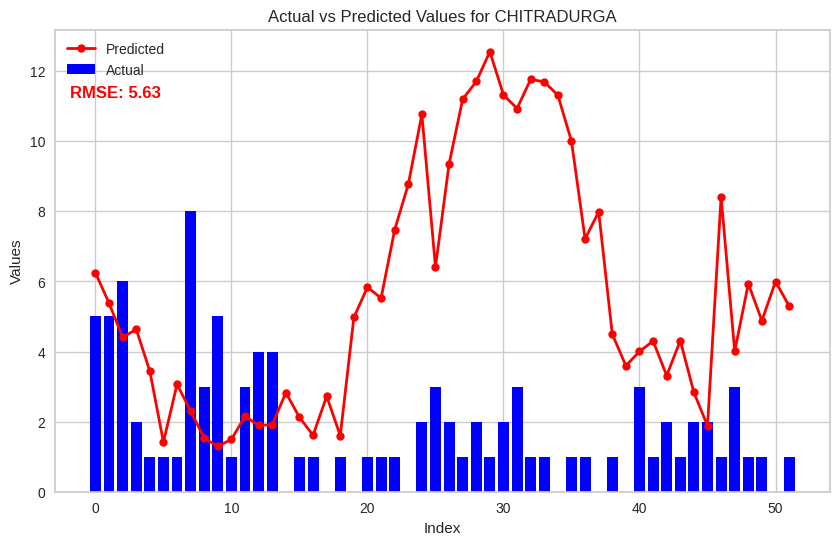

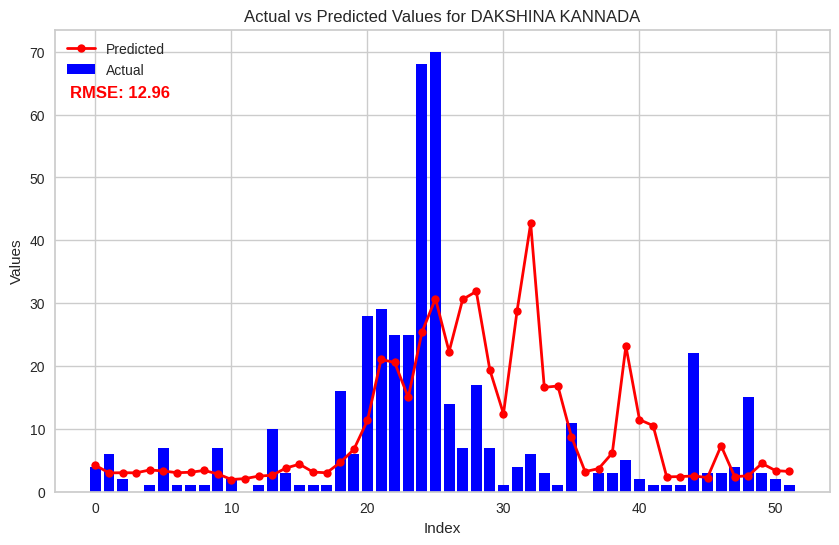

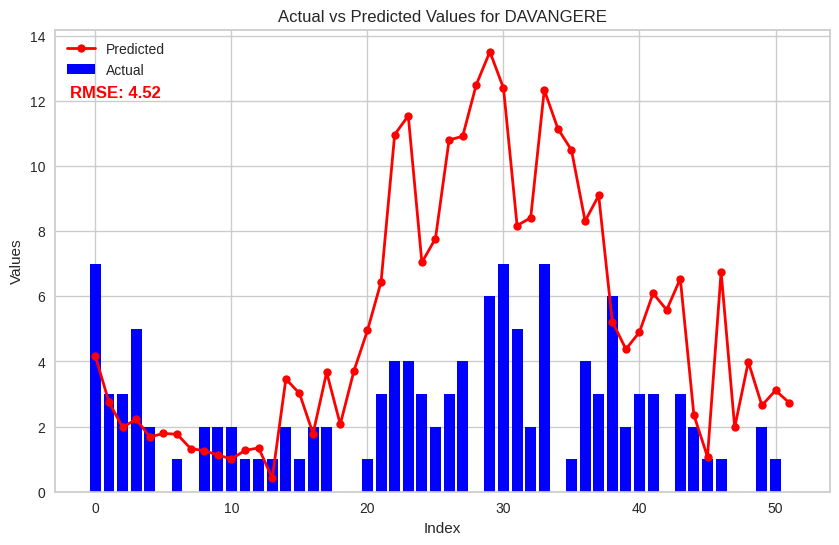

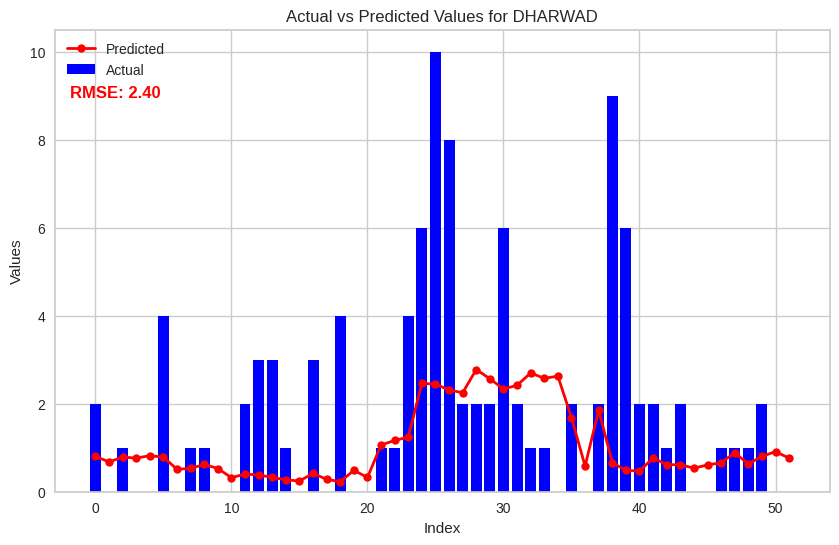

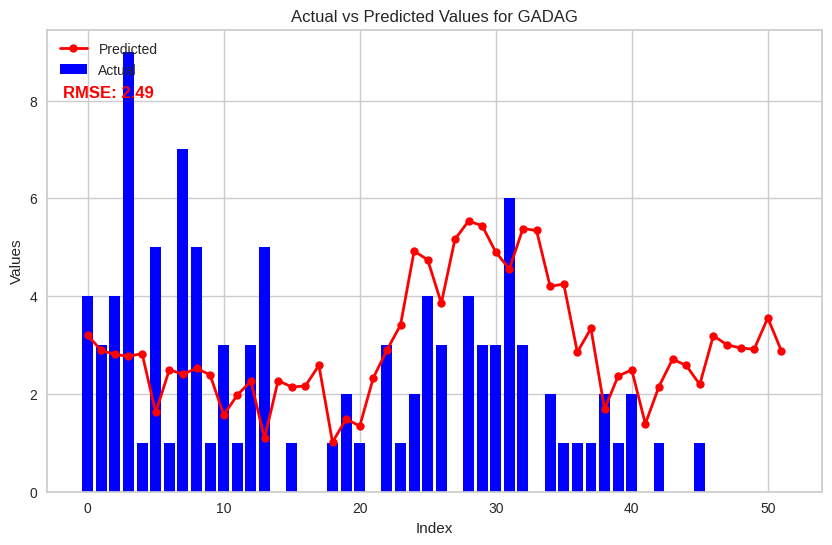

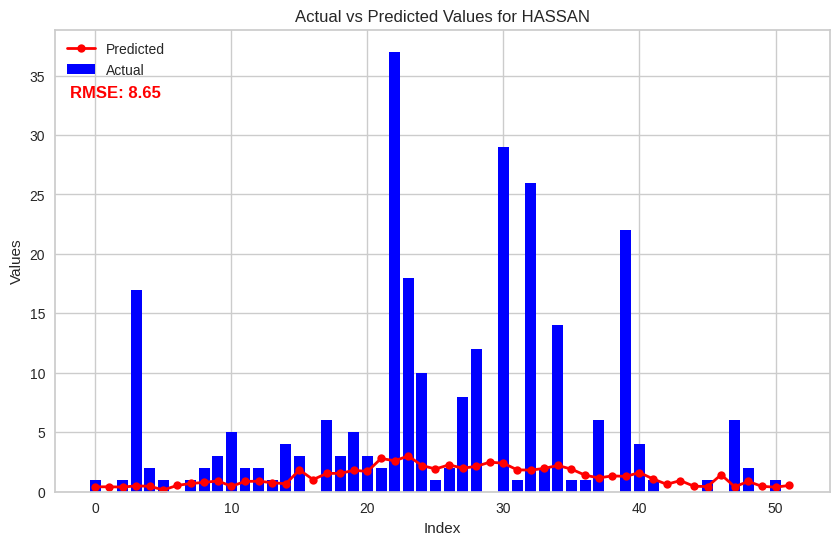

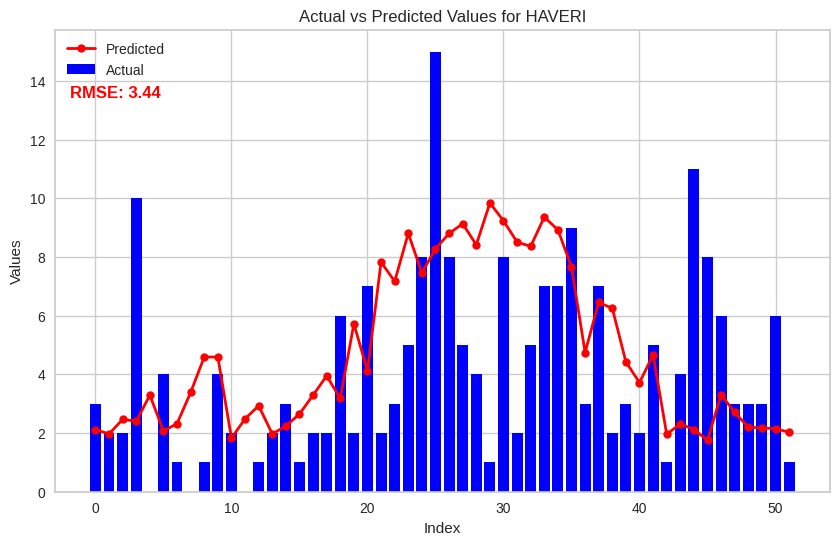

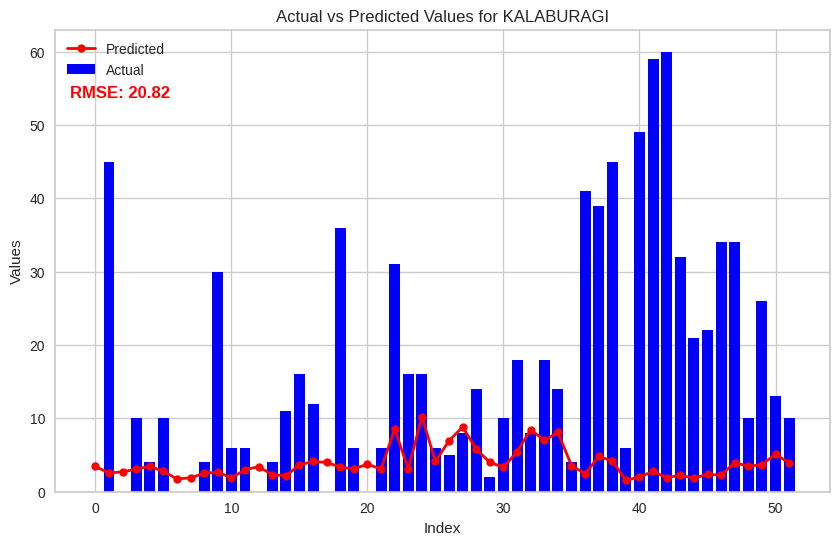

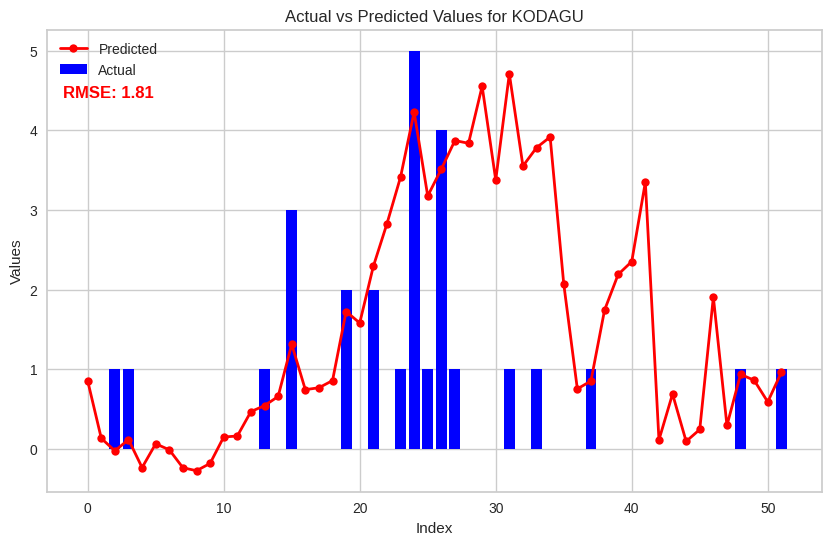

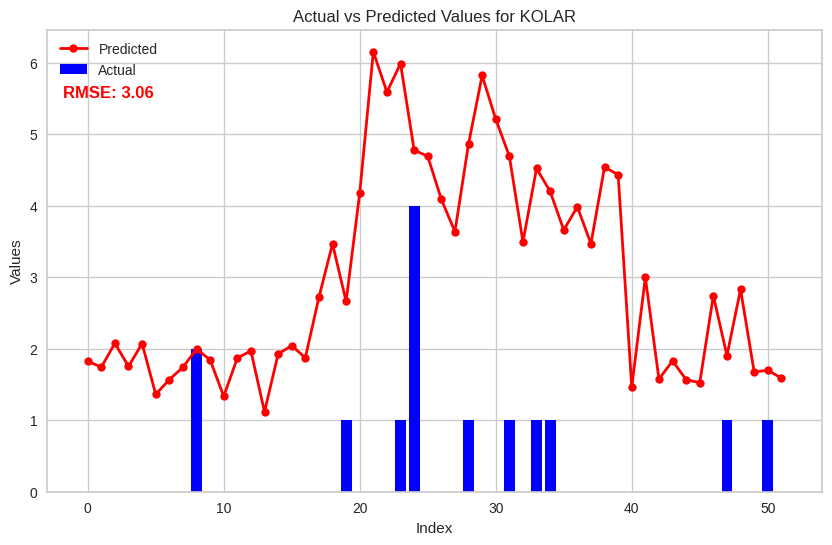

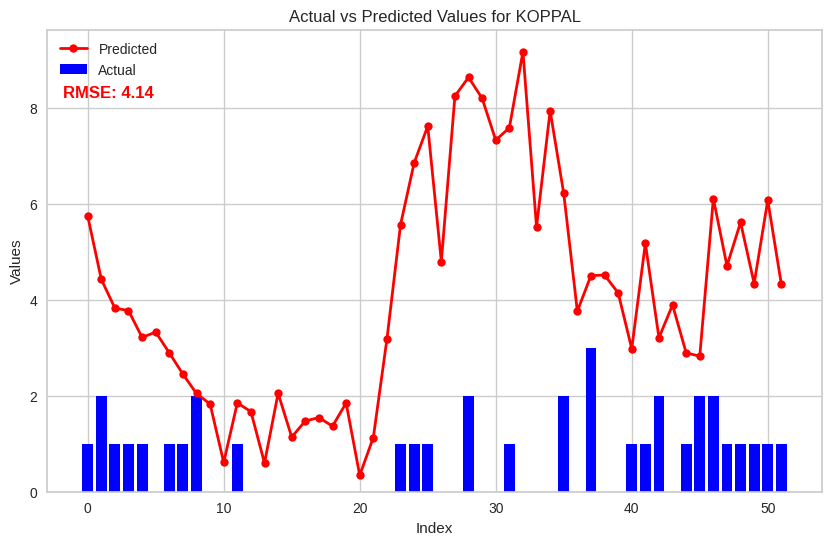

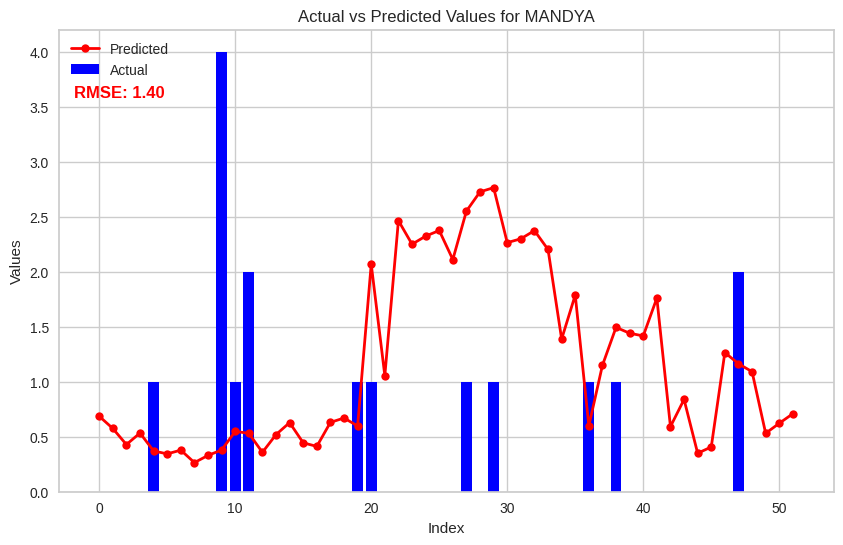

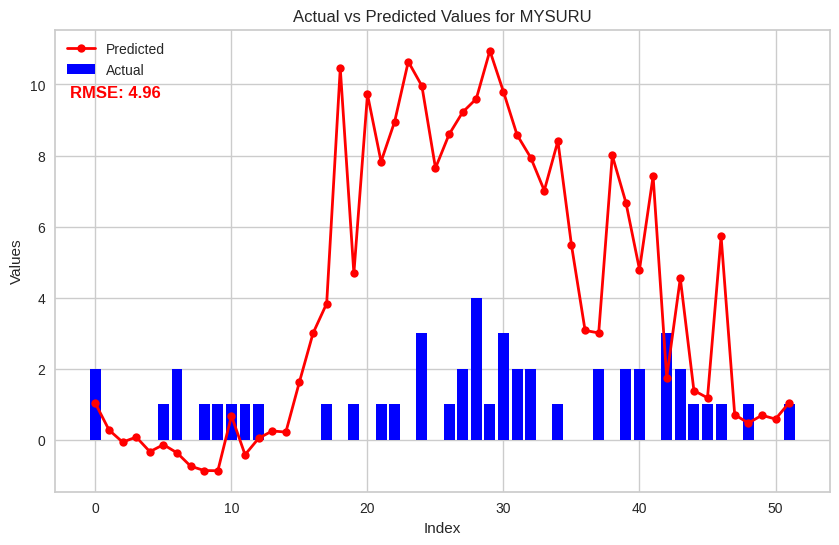

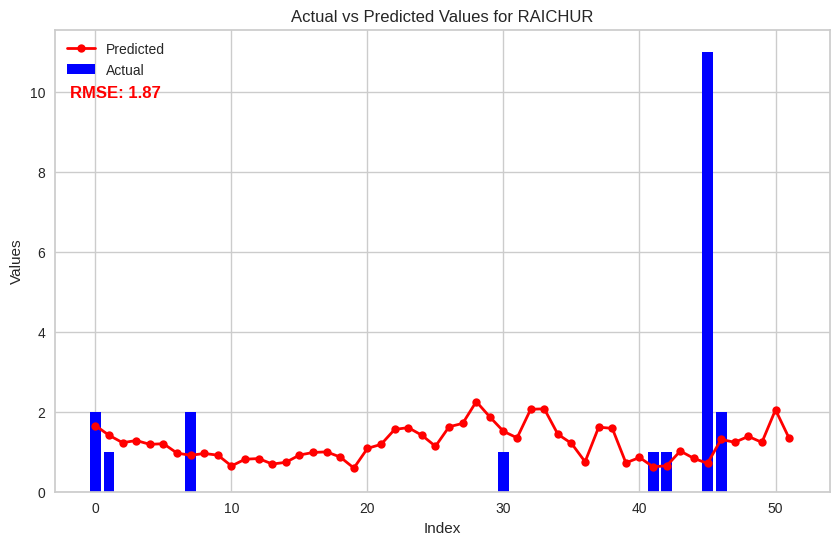

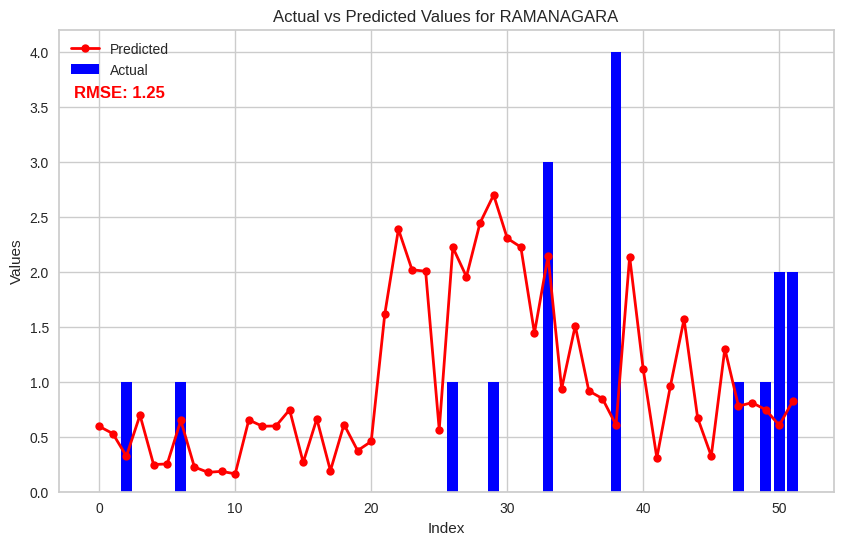

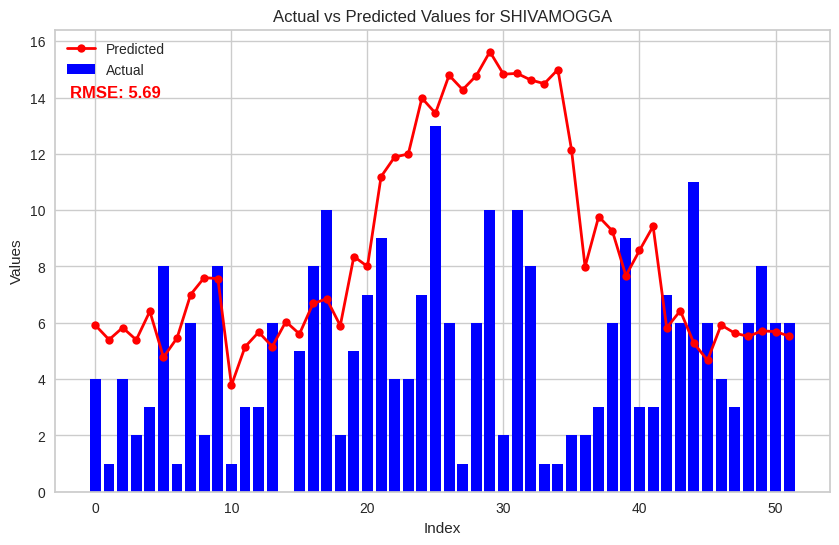

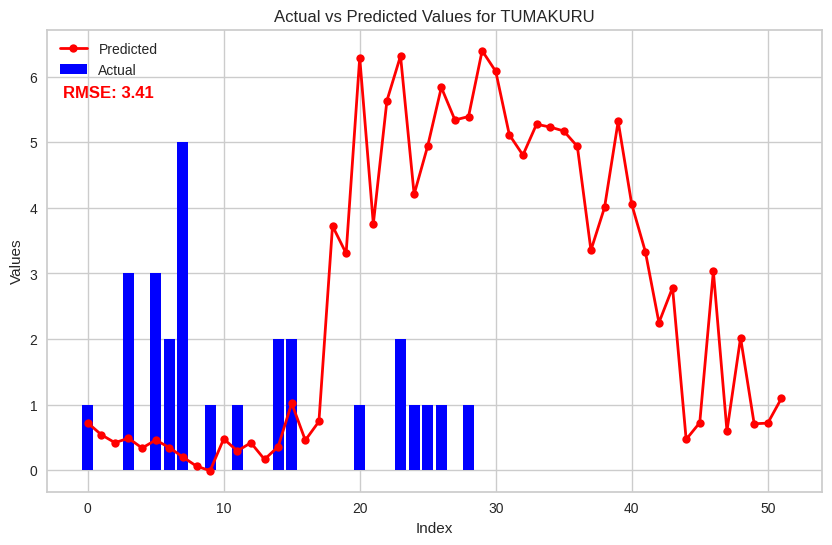

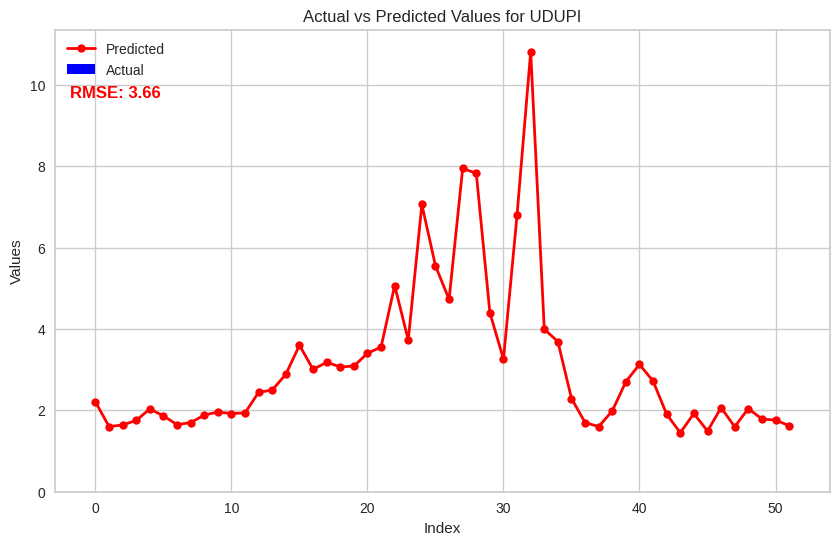

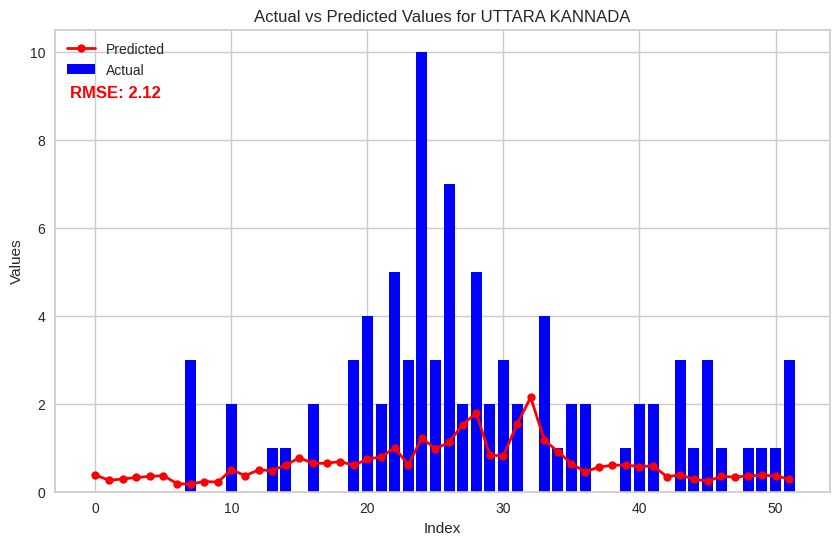

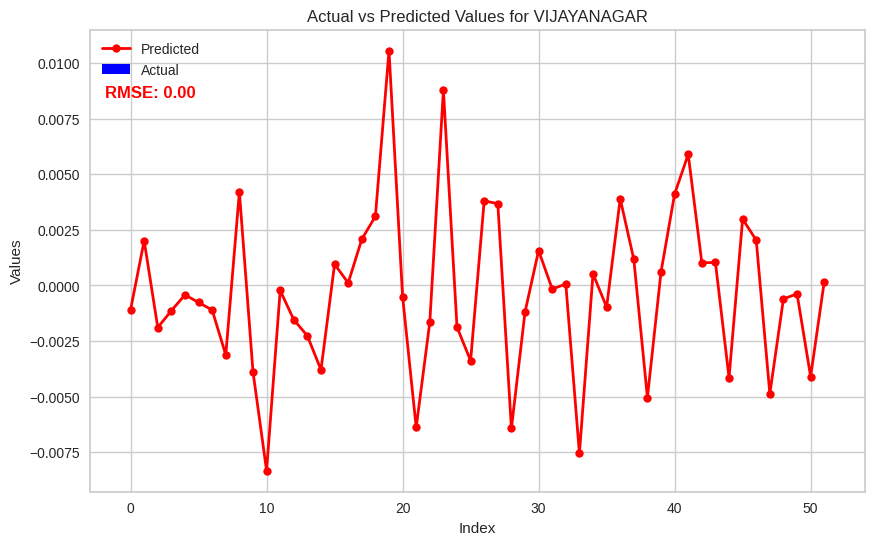

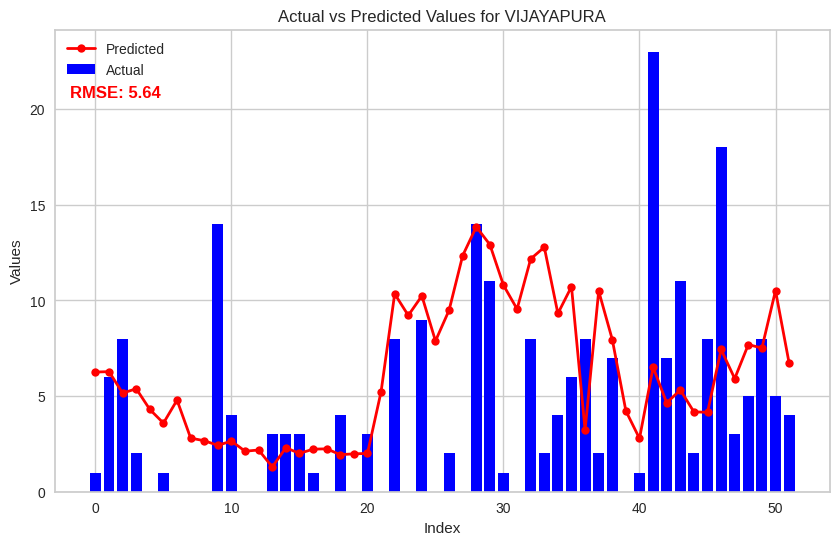

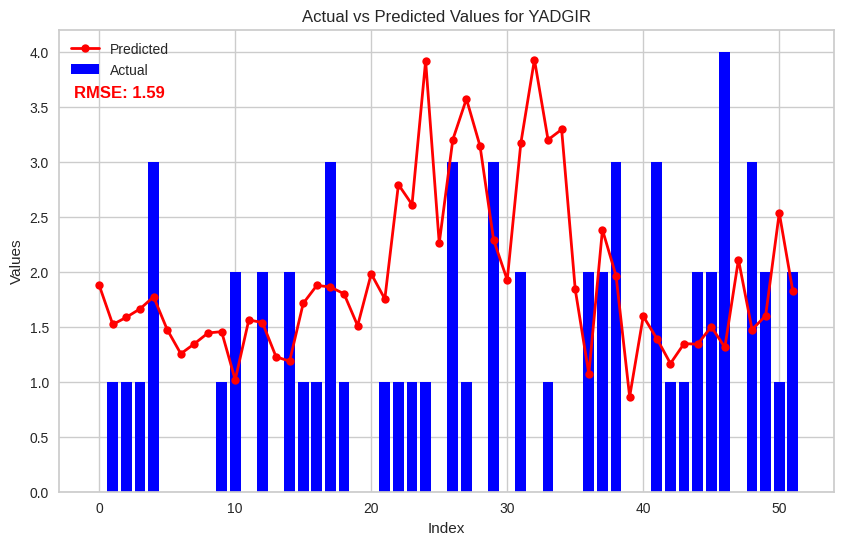

In [26]:
district_analysis_ = DistrictAnalysis_Fine_tuned("Karnataka_weather1980to2022.csv",2018)
df_2018 = district_analysis_.analyze_districts()

Trial 5 Complete [00h 03m 35s]
mse: 9.313692665100097

Best mse So Far: 9.313692665100097
Total elapsed time: 00h 17m 55s
Search completed!


Best Model saved successfully!
Best Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,313 (5.13 KB)

 Trainable params: 1,313 (5.13 KB)

 Non-trainable params: 0 (0.00 B)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


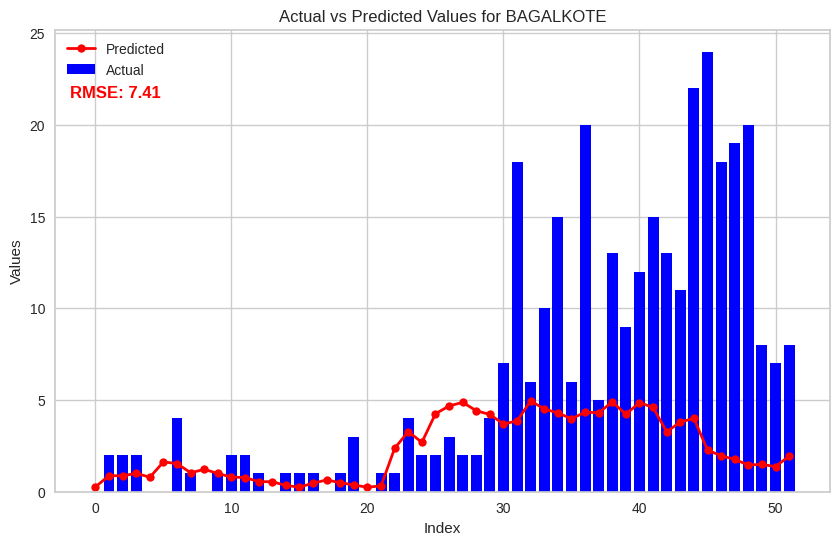

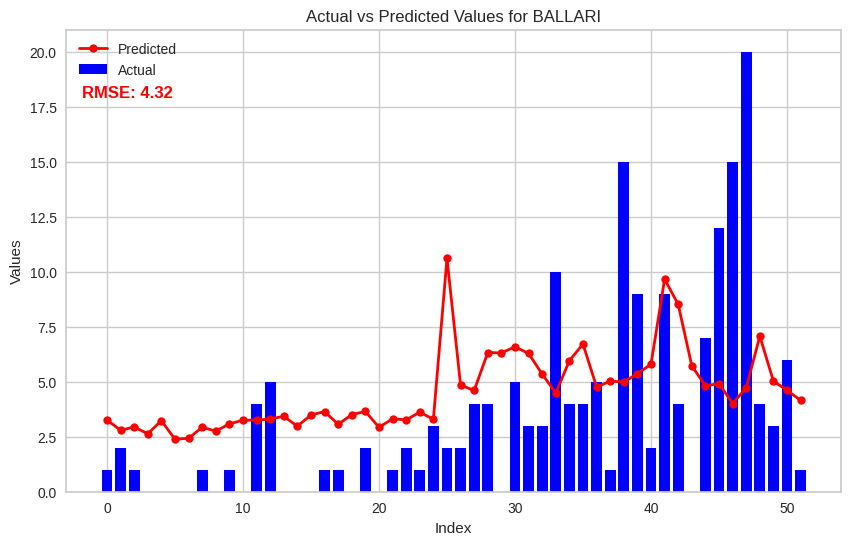

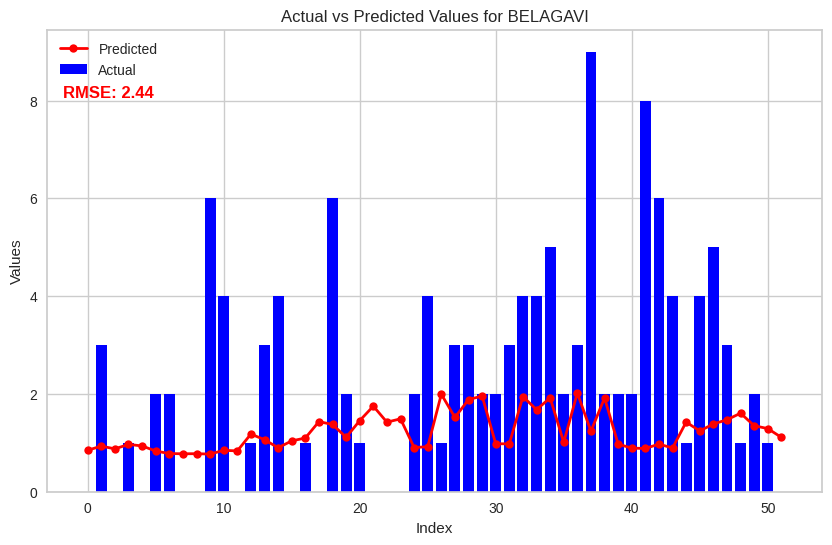

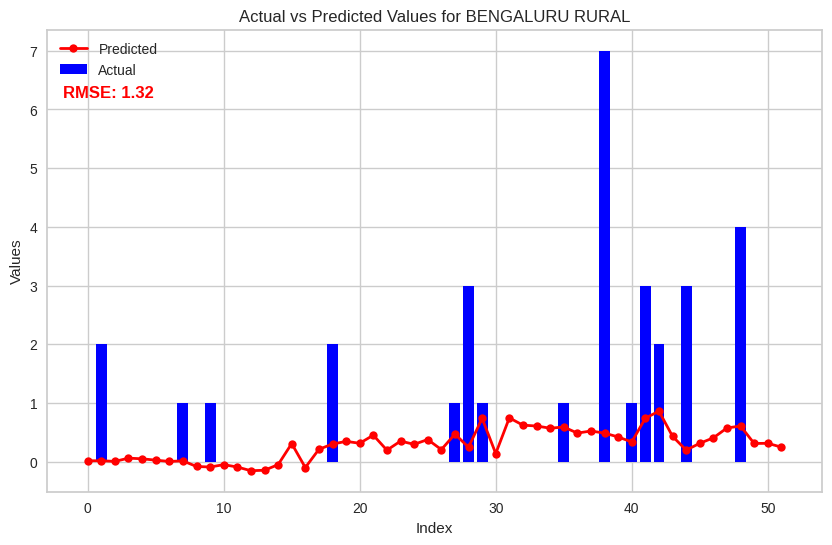

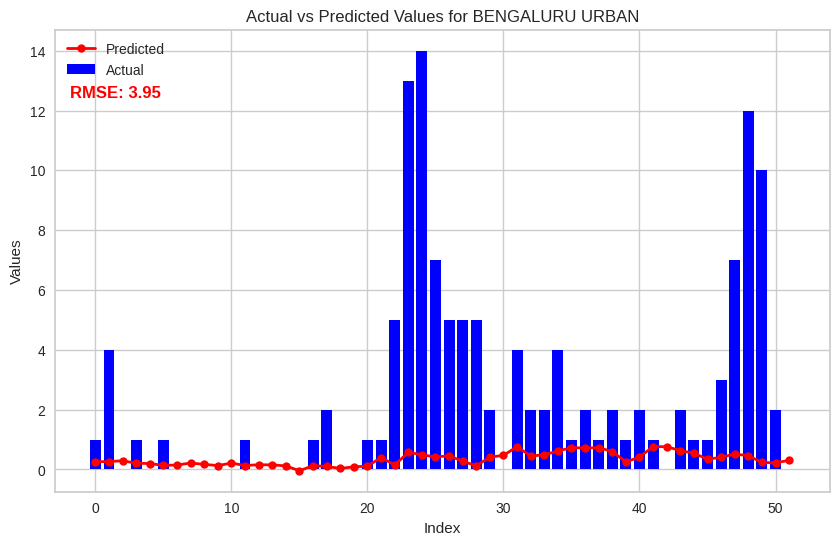

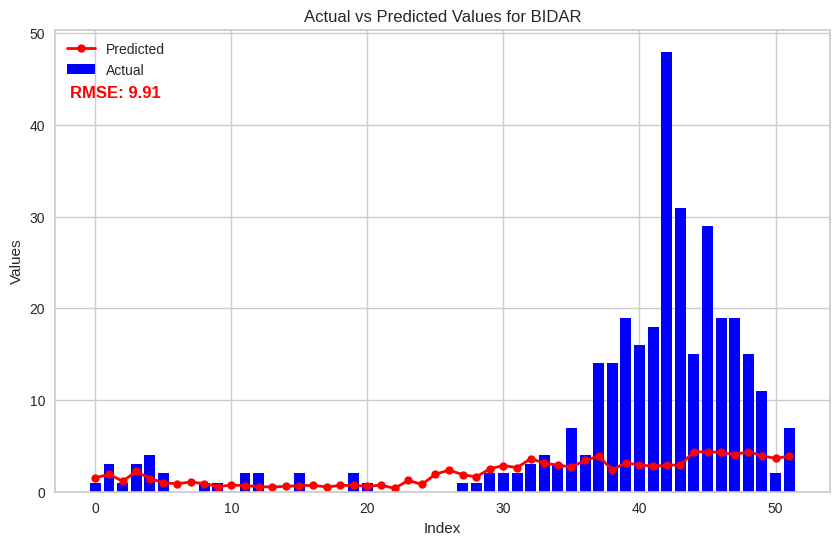

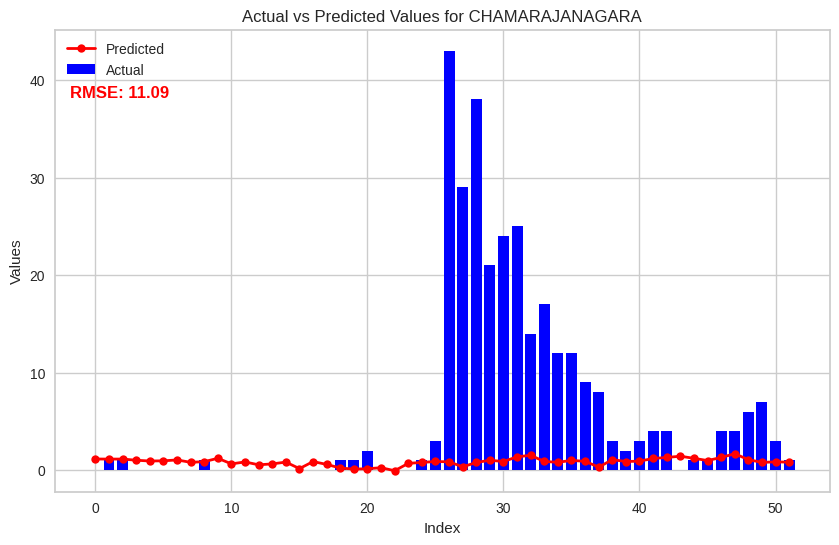

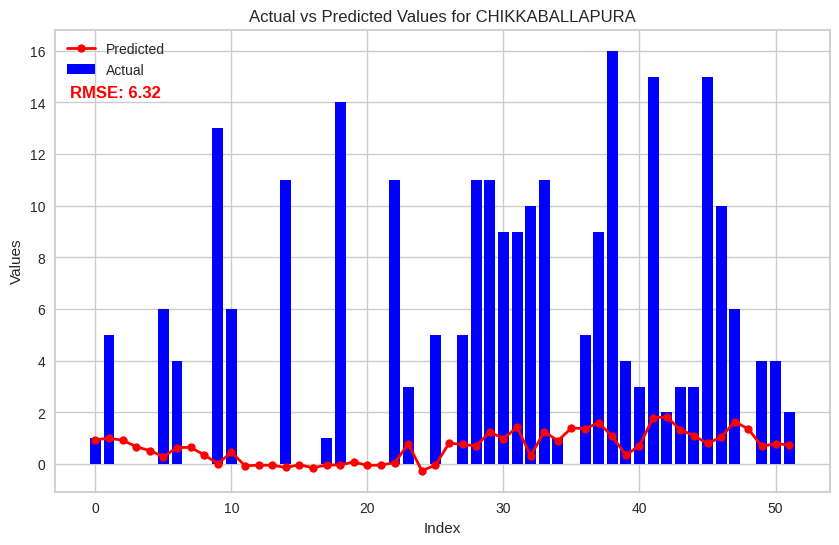

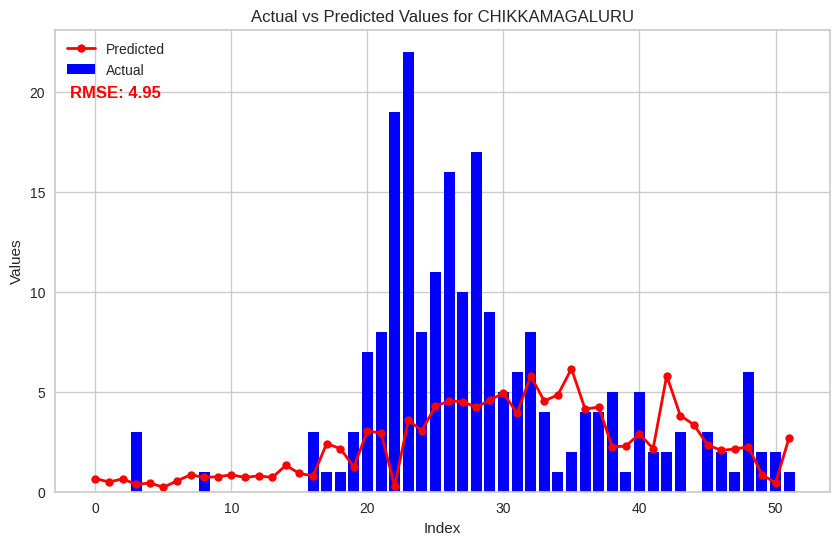

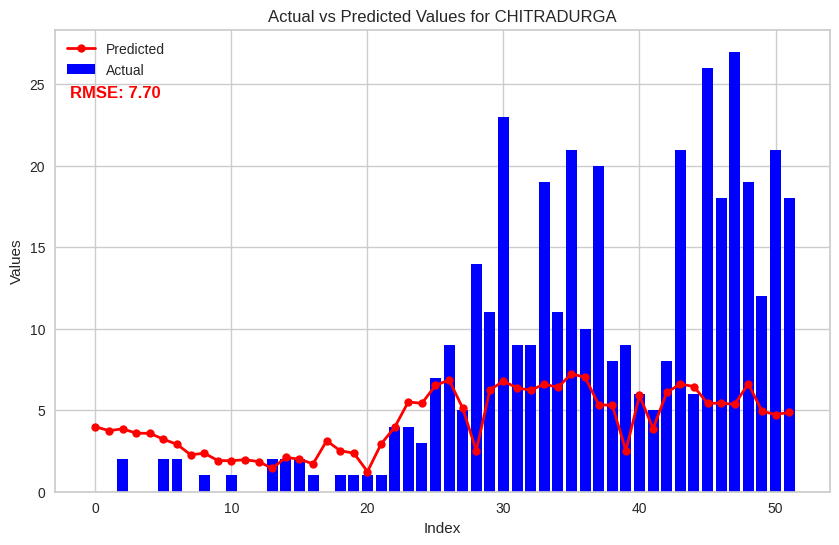

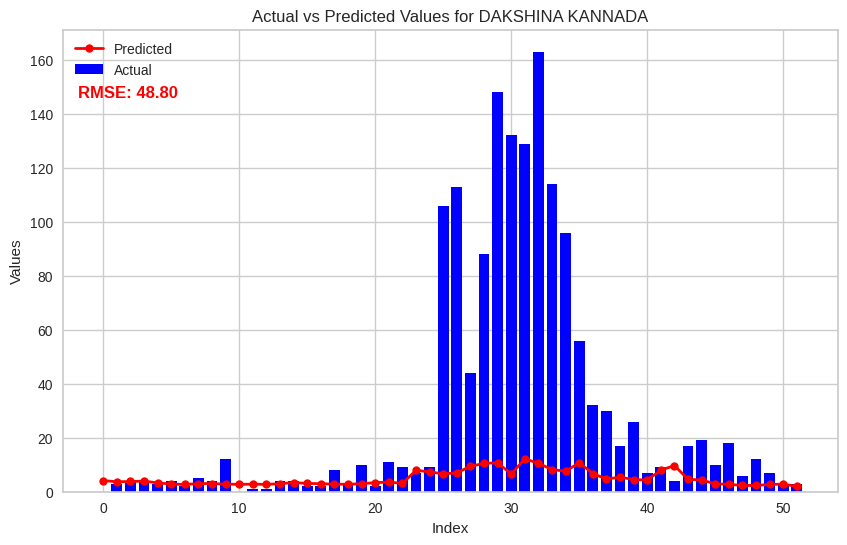

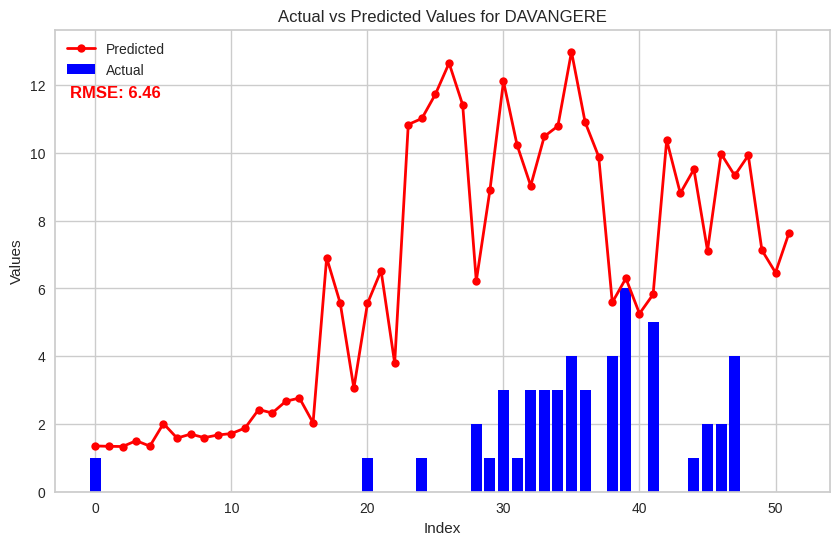

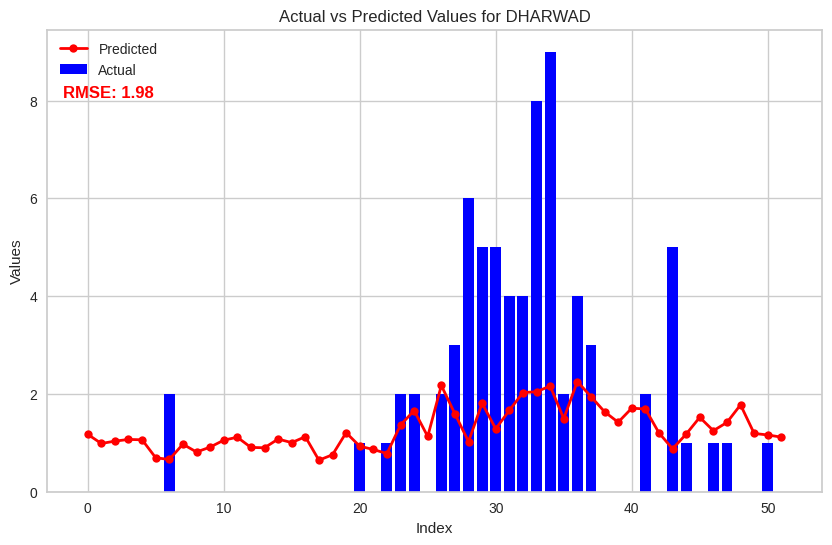

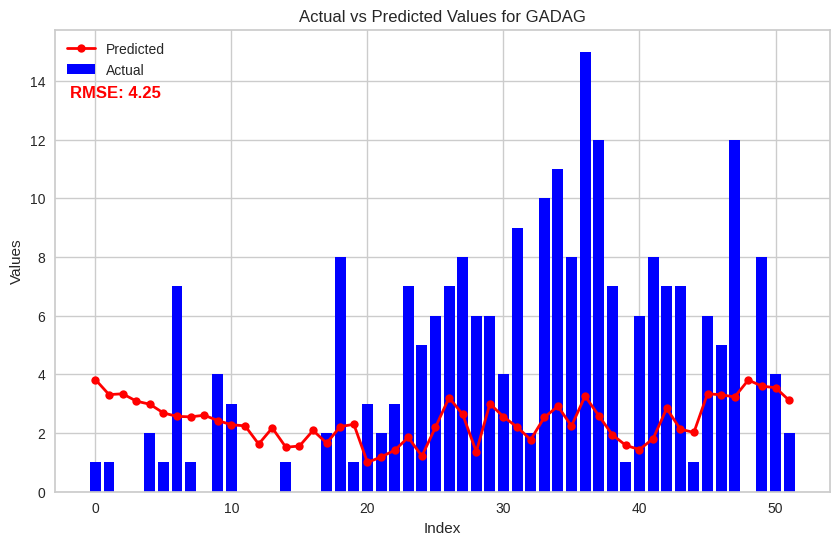

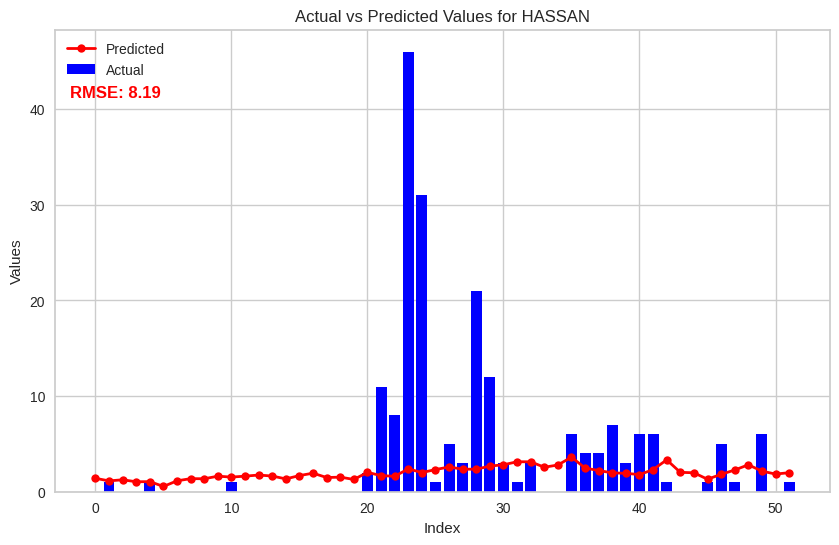

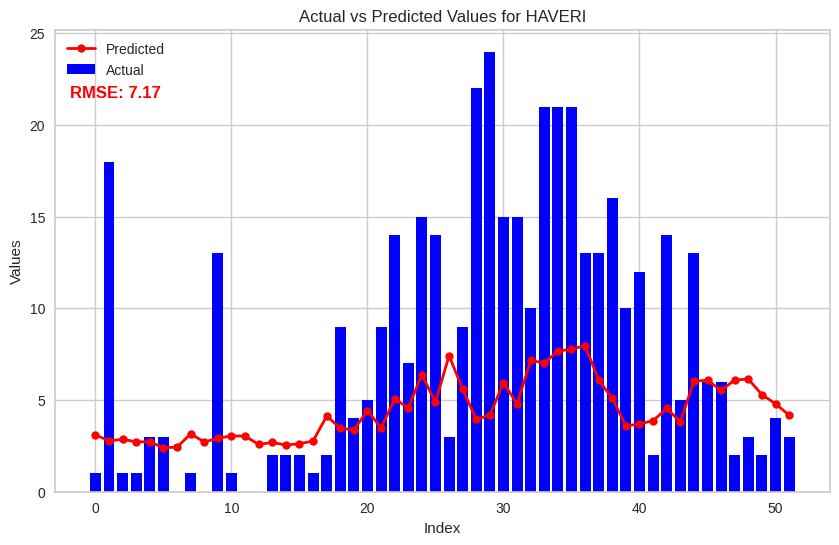

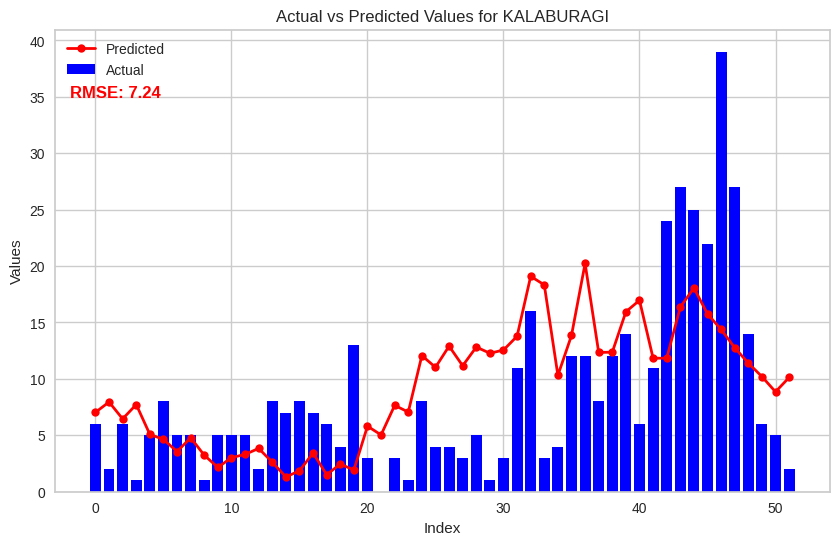

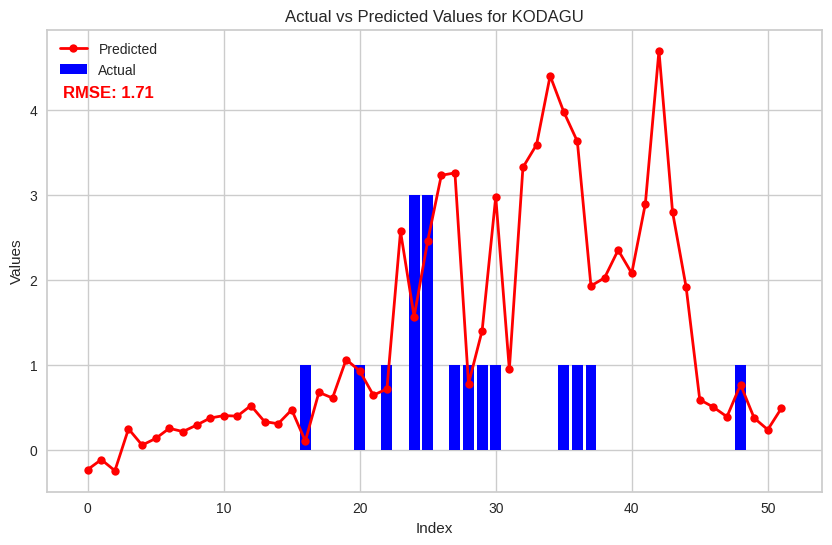

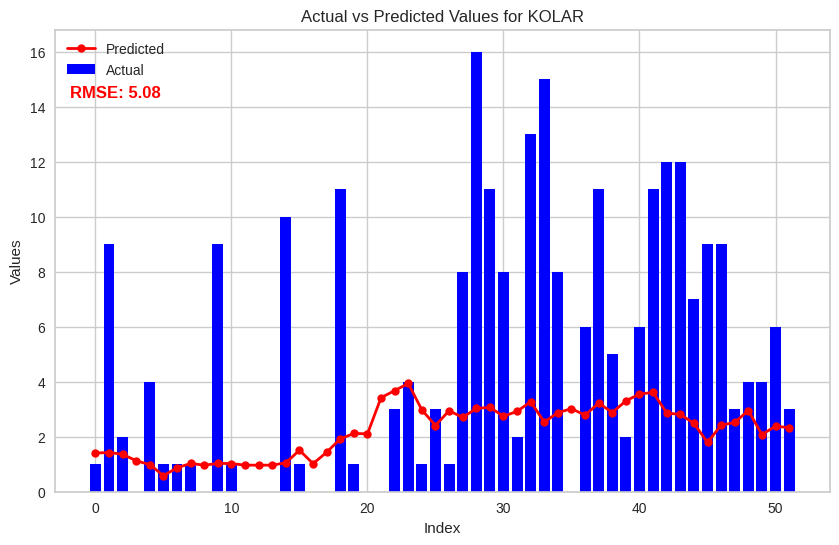

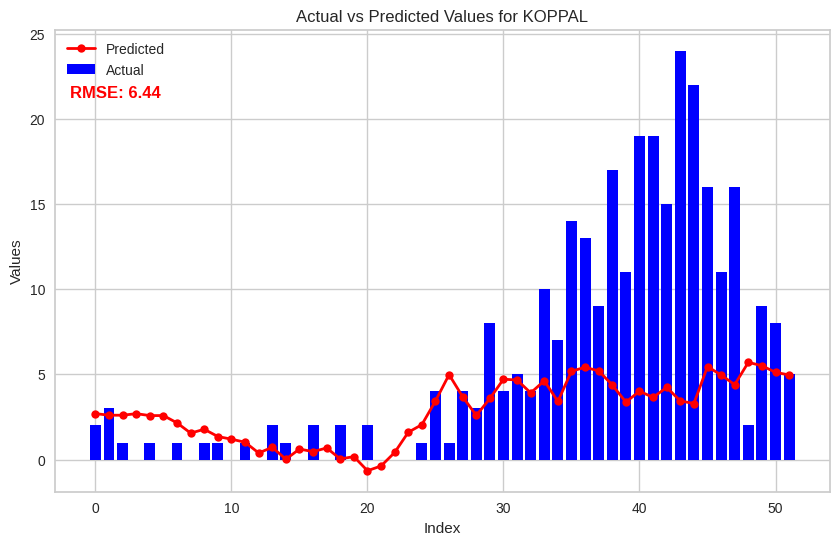

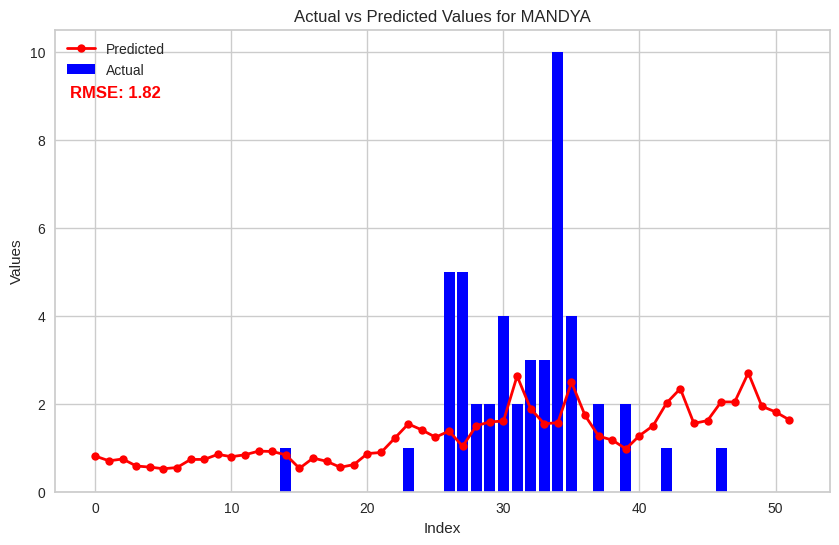

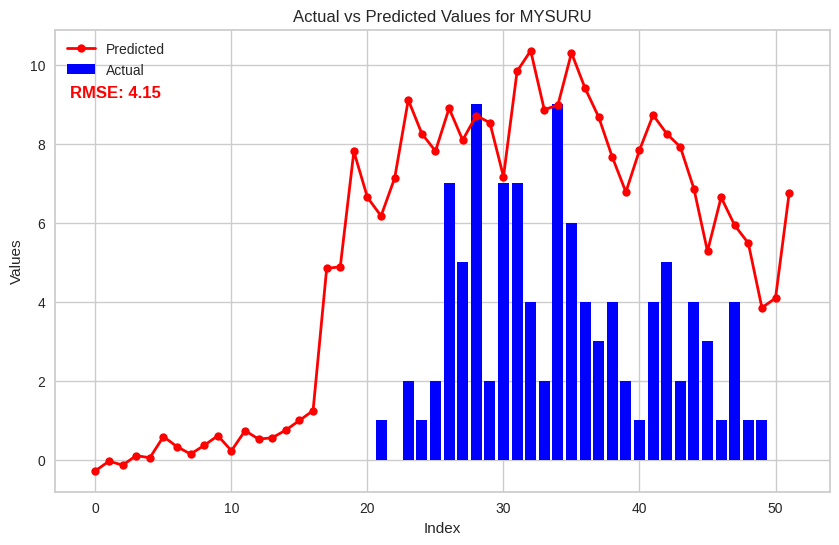

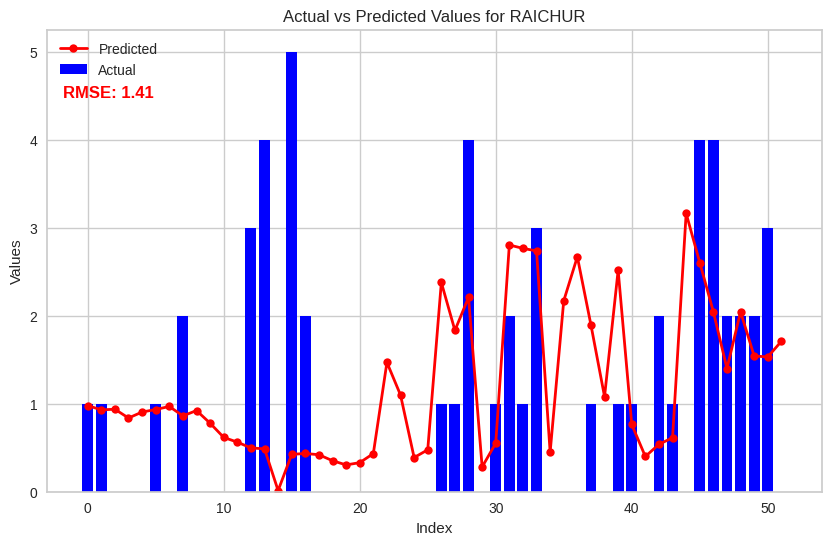

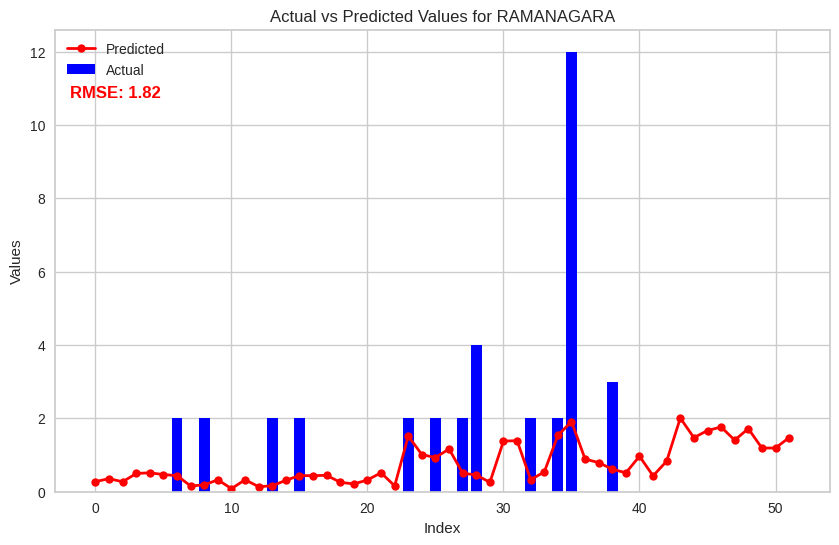

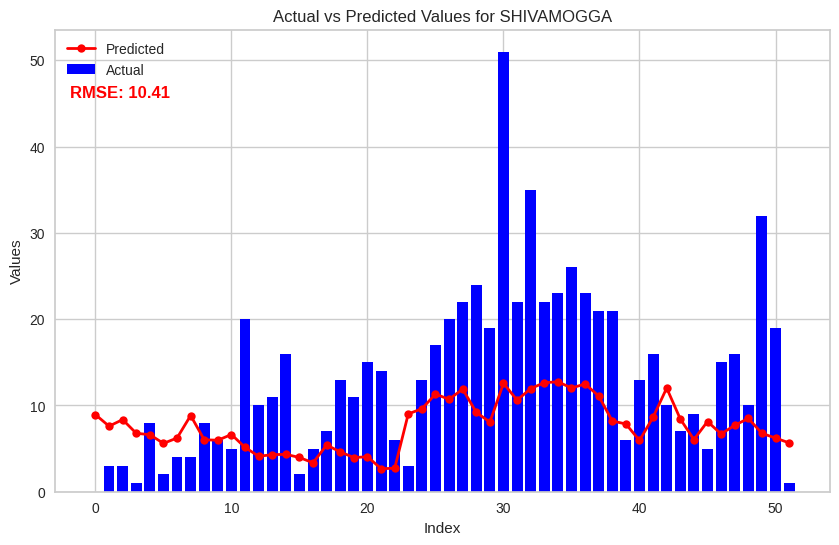

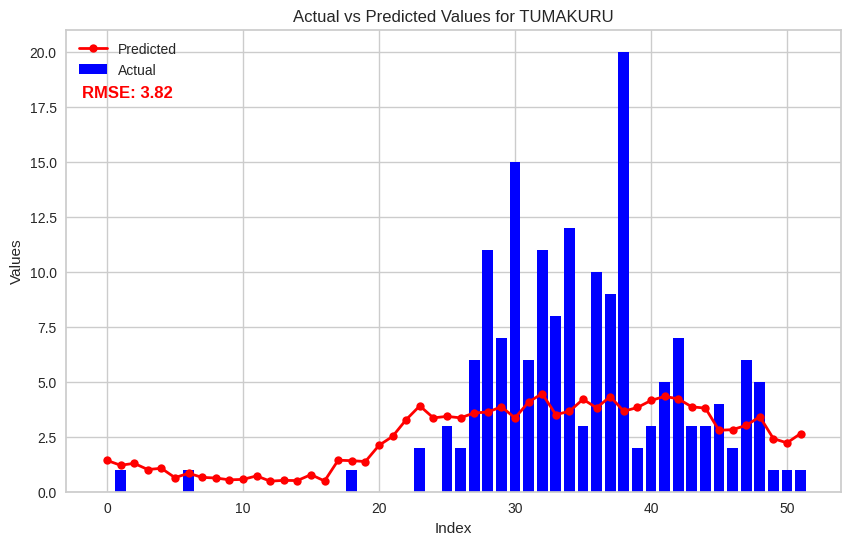

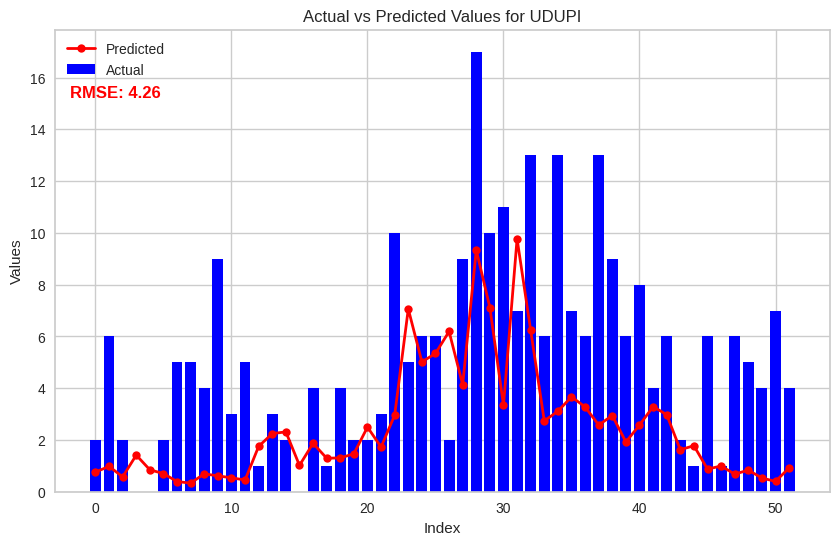

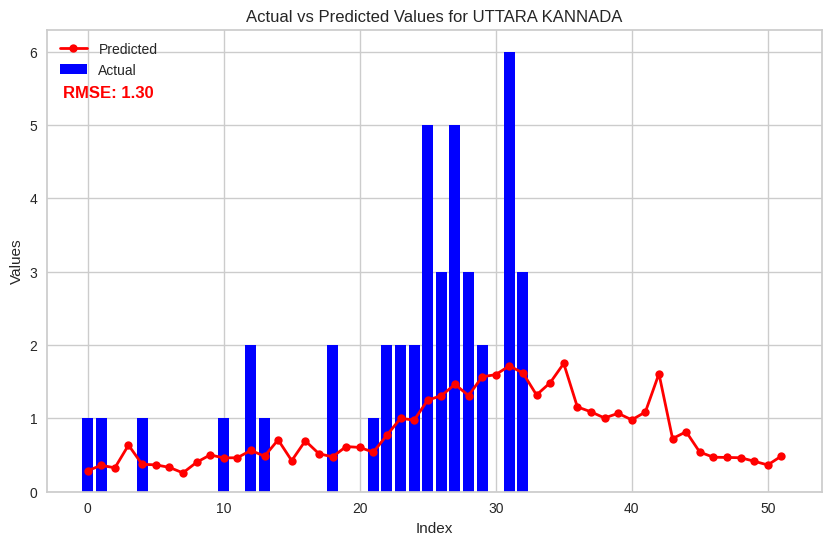

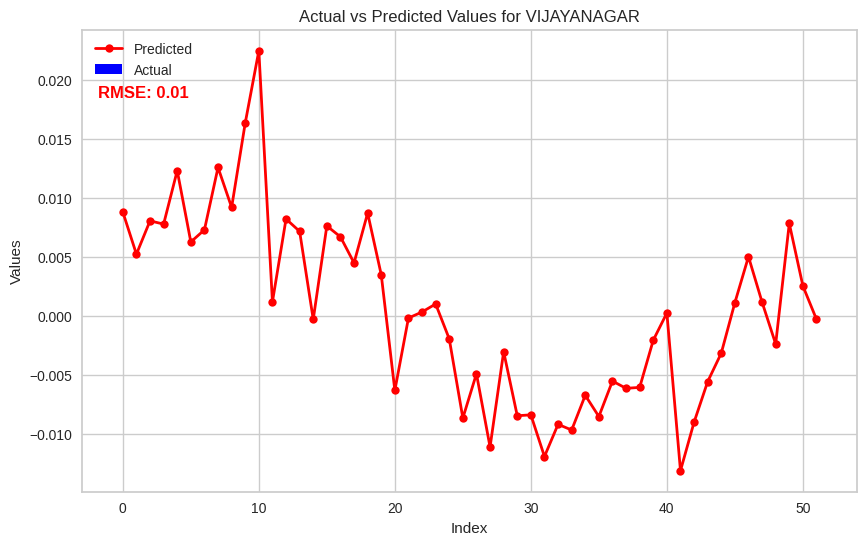

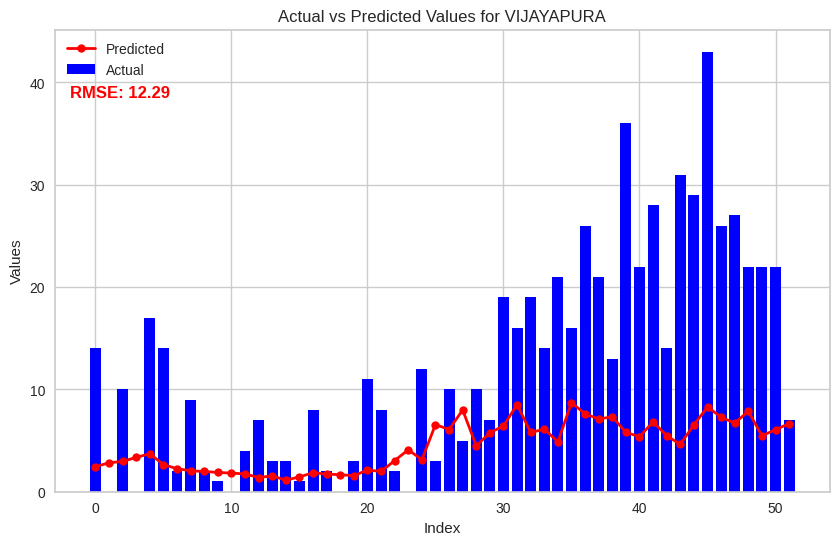

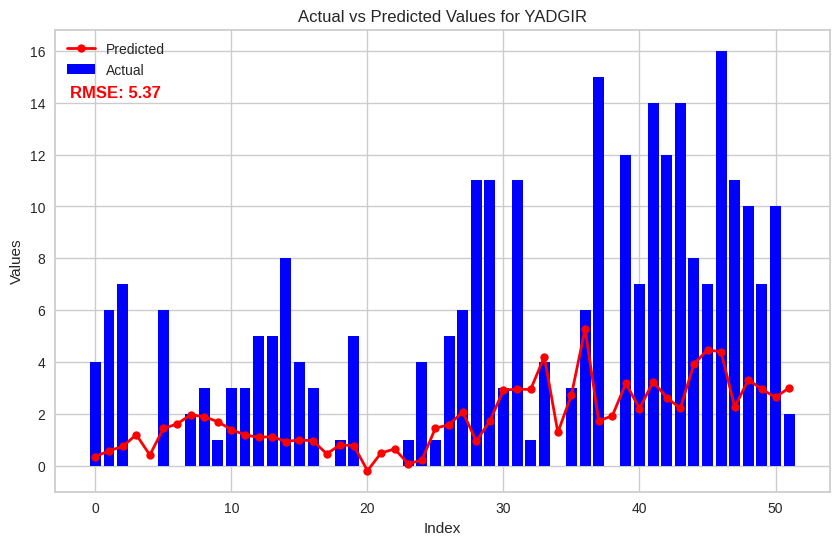

In [27]:
district_analysis_ = DistrictAnalysis_Fine_tuned("Karnataka_weather1980to2022.csv",2019)
df_2019 = district_analysis_.analyze_districts()

Trial 5 Complete [00h 03m 59s]
mse: 12.636341285705566

Best mse So Far: 12.207281494140625
Total elapsed time: 00h 19m 55s
Search completed!


Best Model saved successfully!
Best Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,481 (17.50 KB)

 Trainable params: 4,481 (17.50 KB)

 Non-trainable params: 0 (0.00 B)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


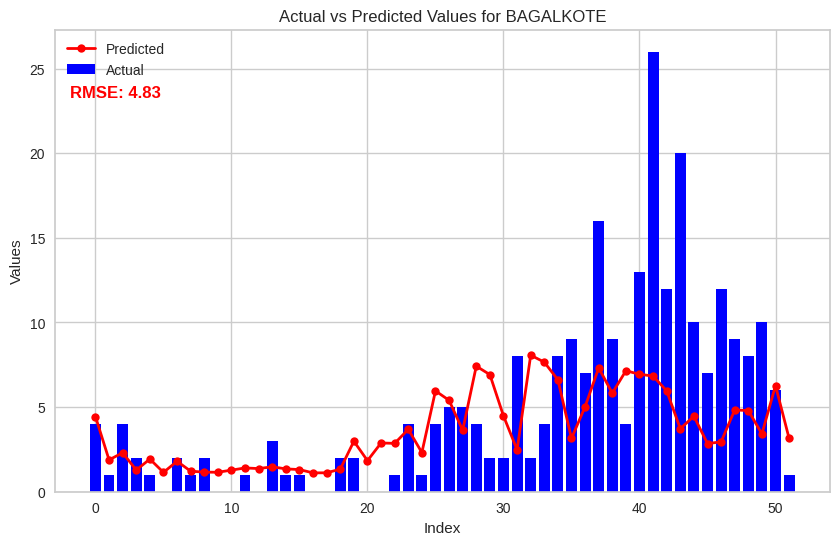

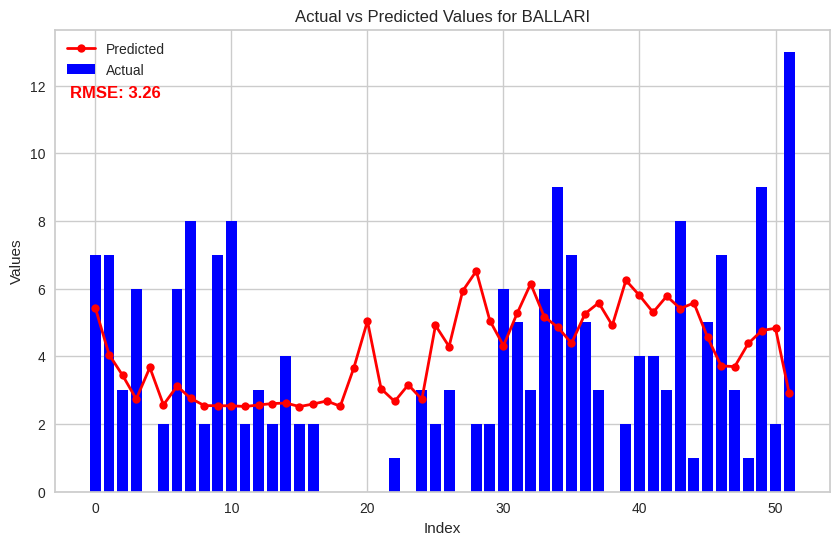

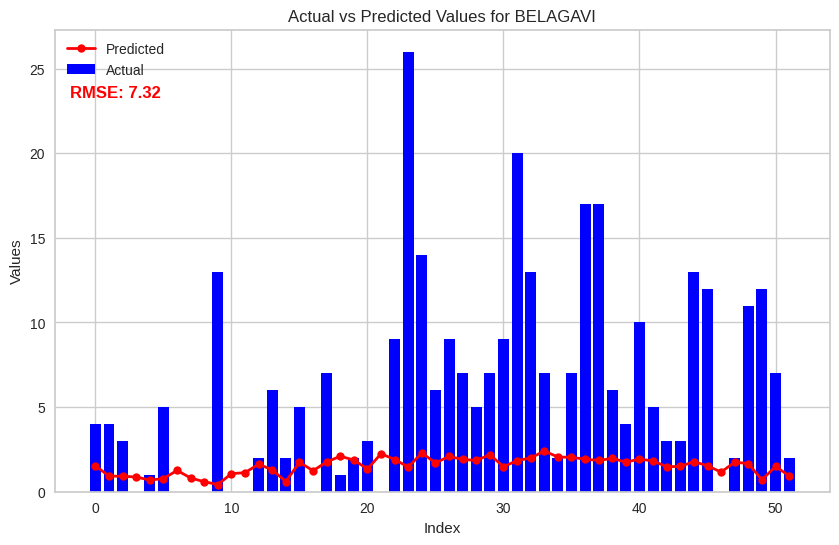

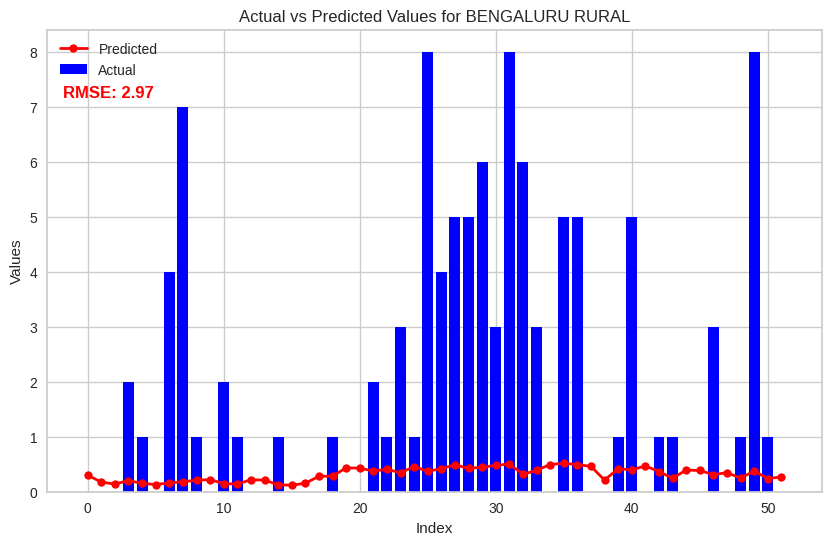

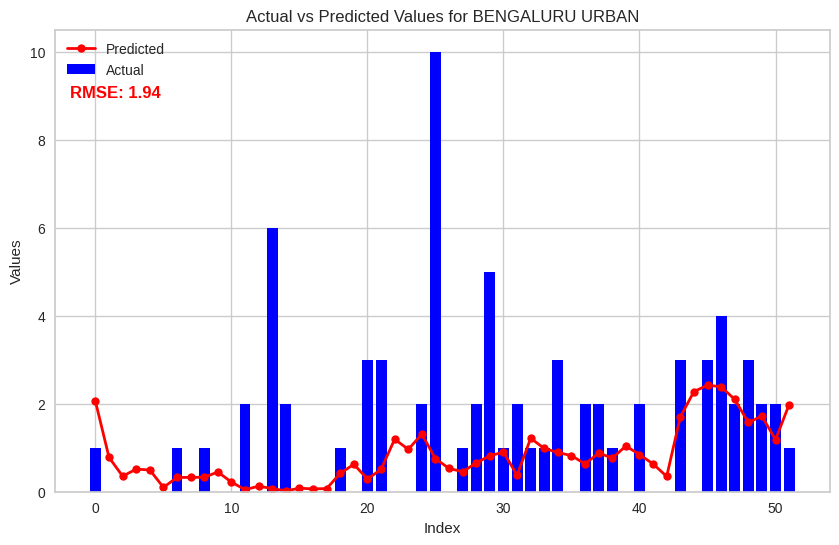

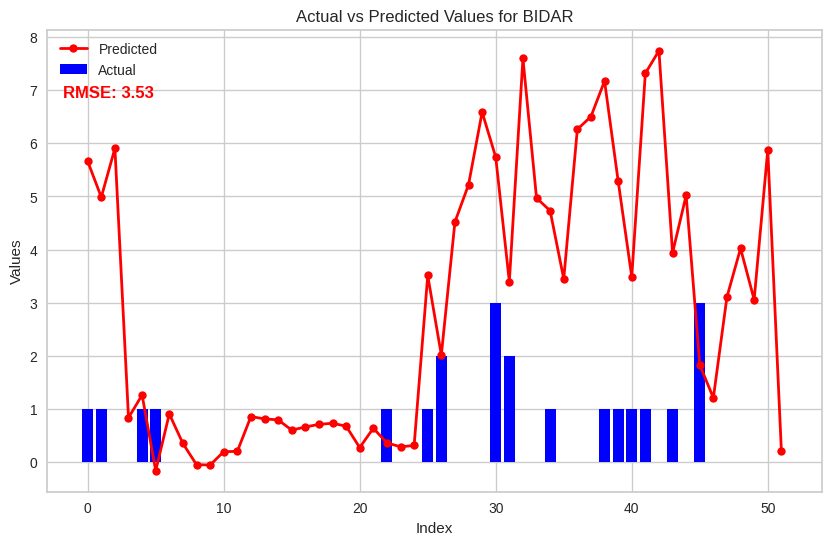

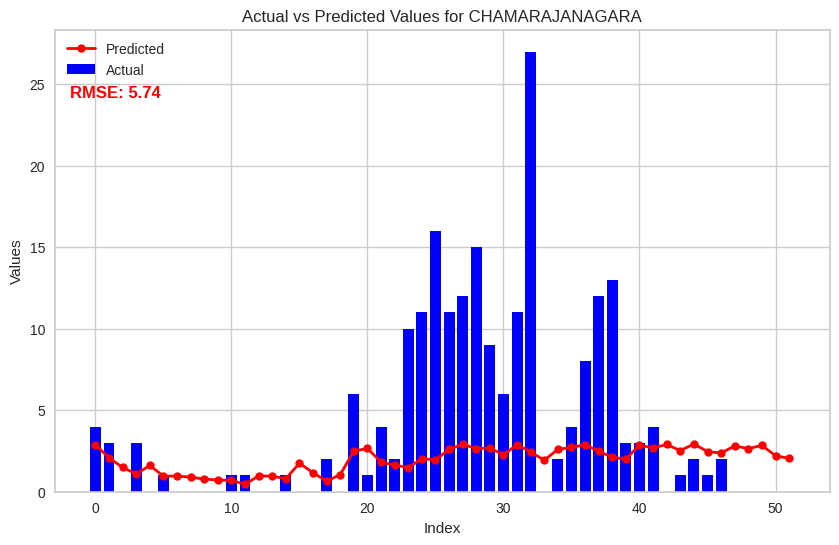

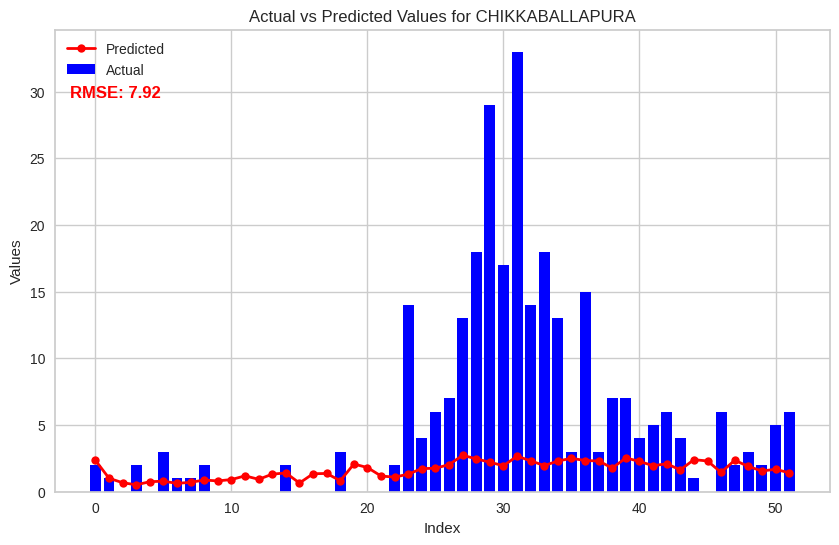

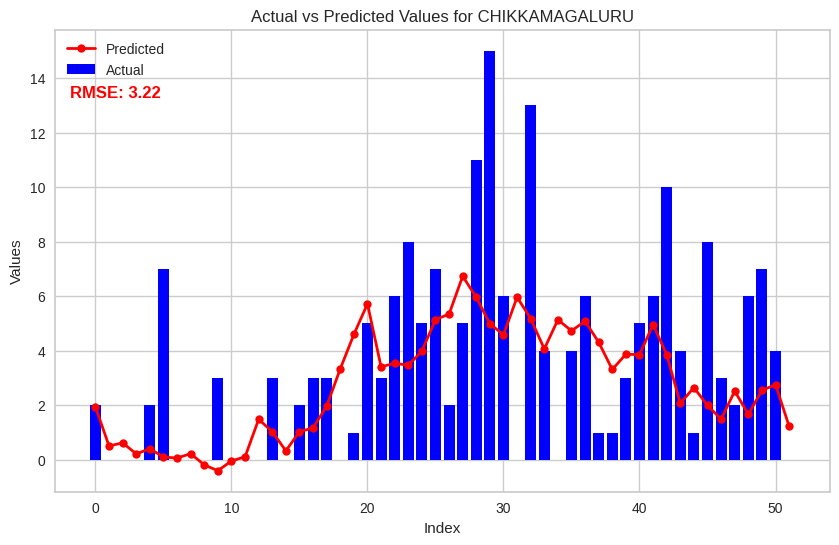

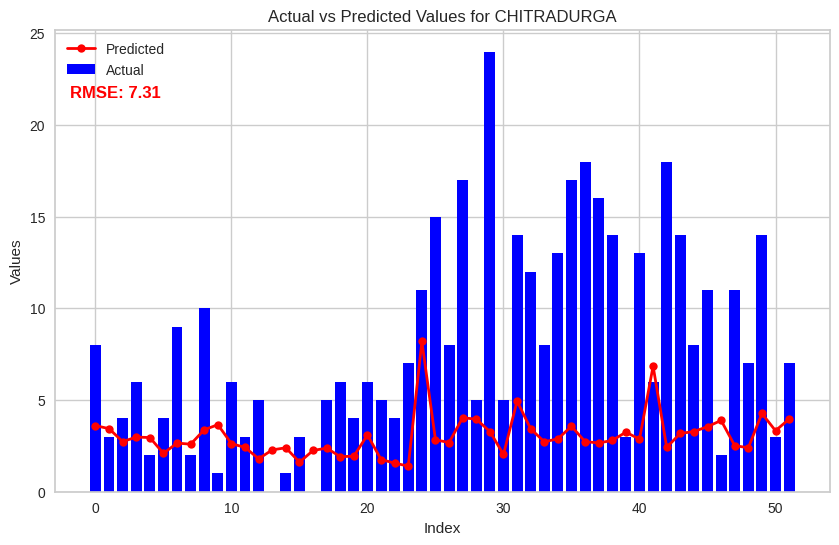

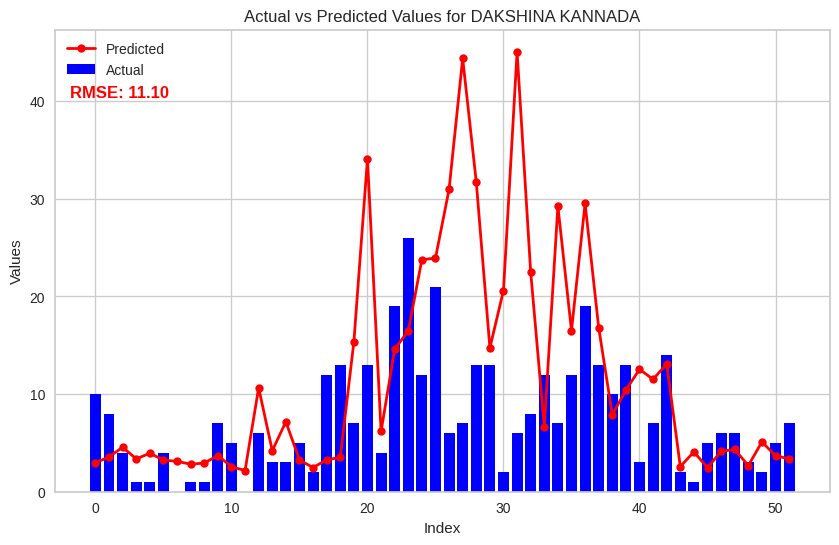

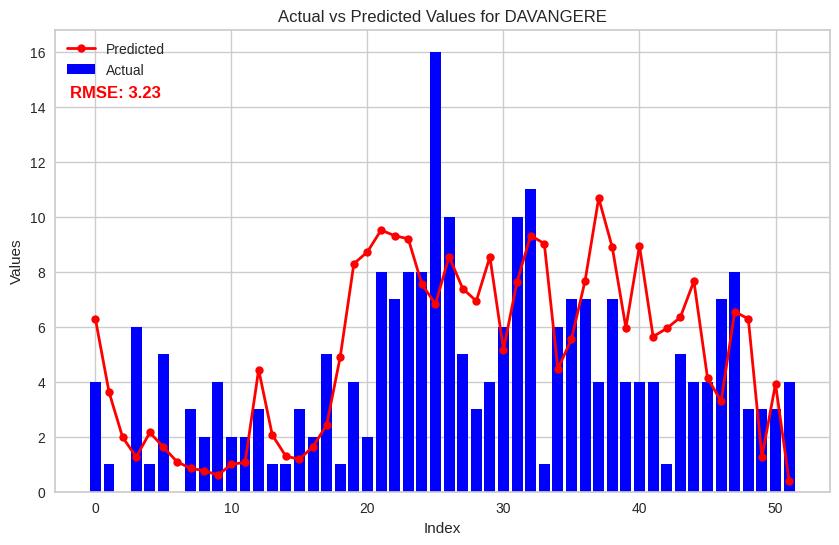

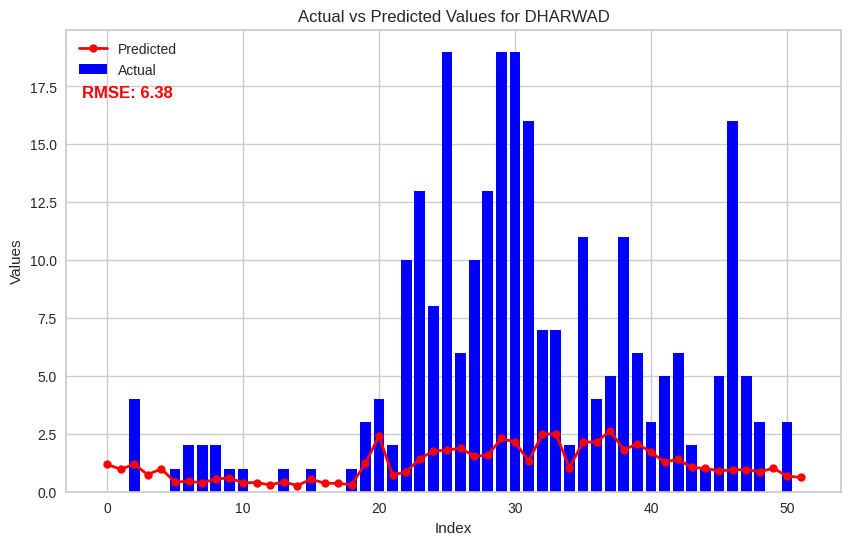

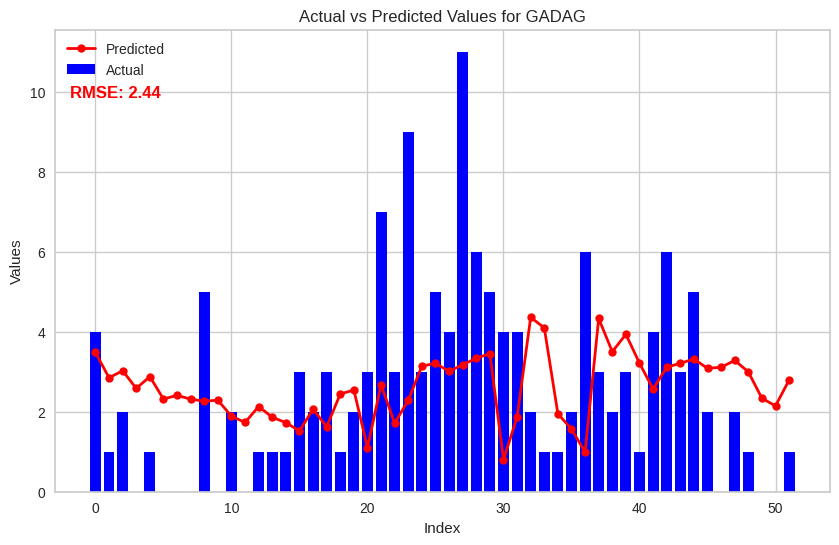

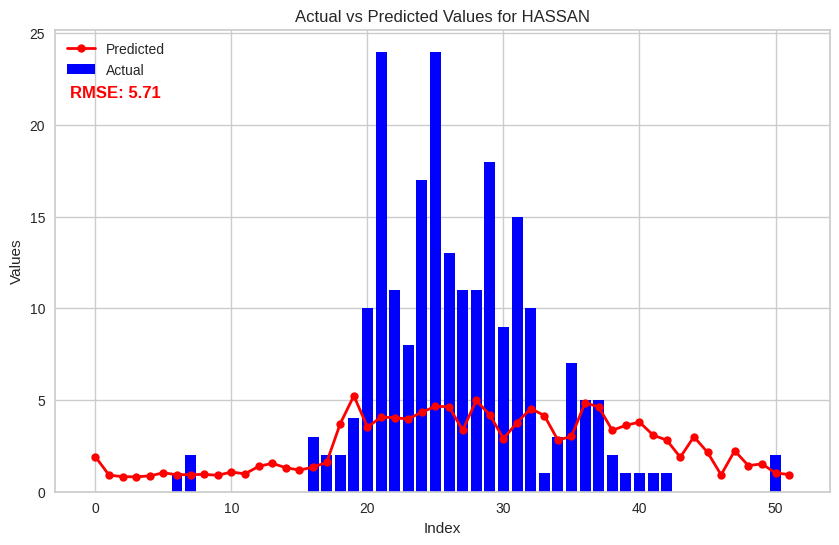

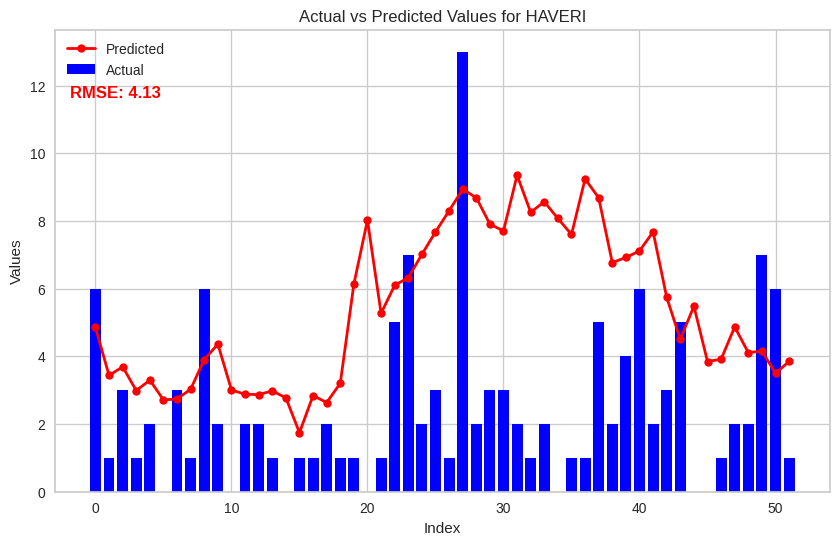

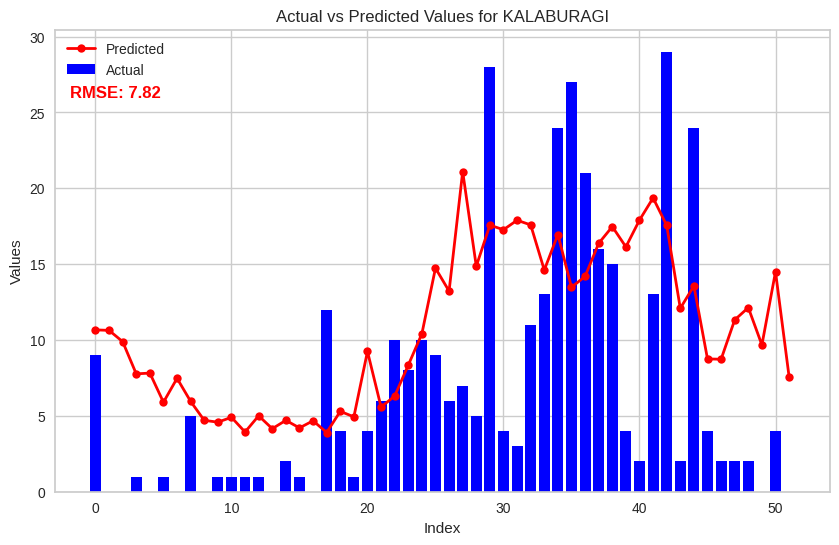

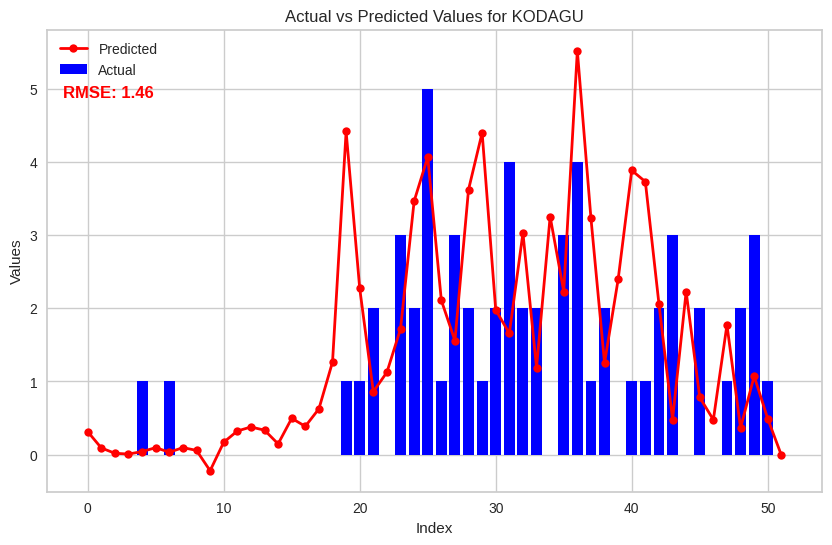

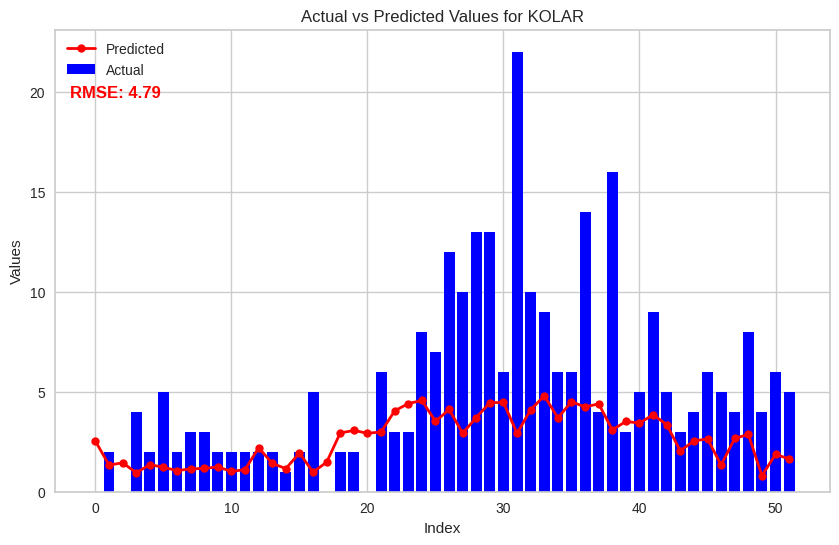

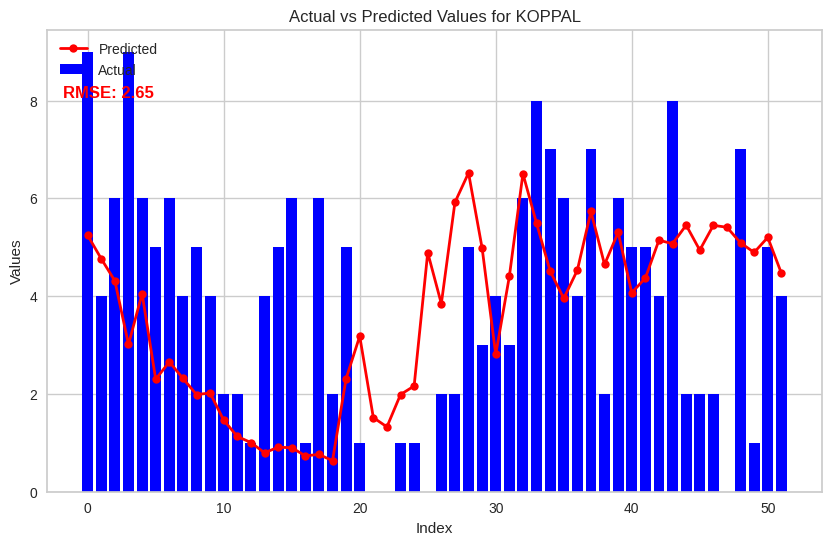

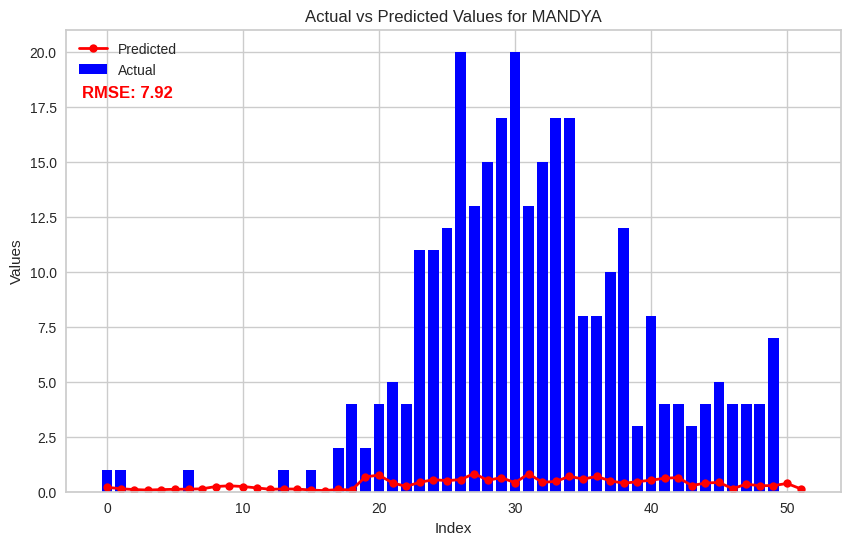

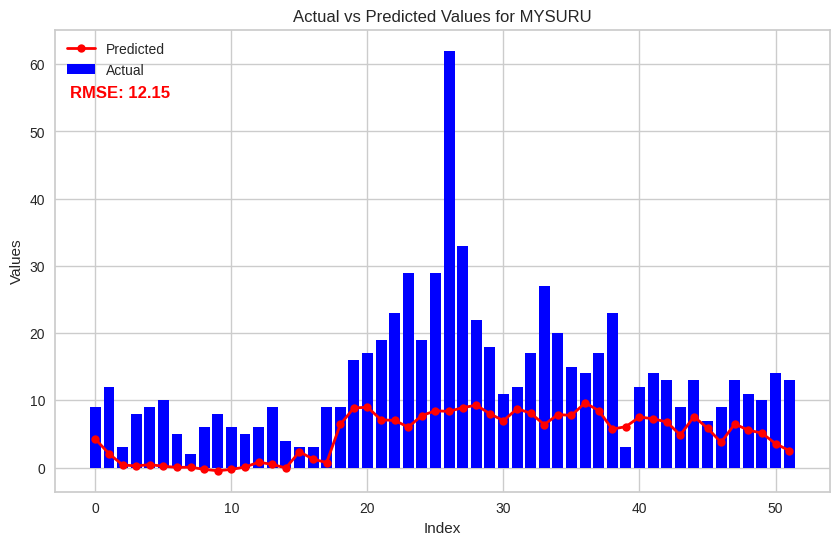

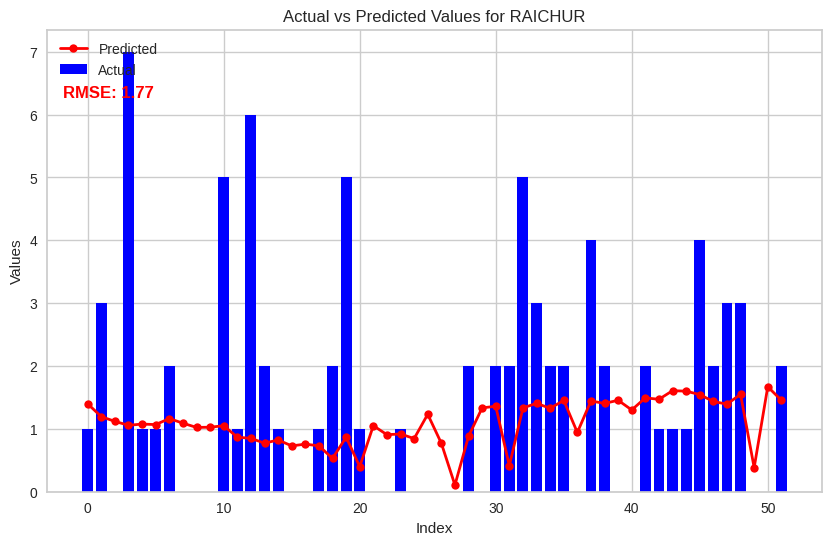

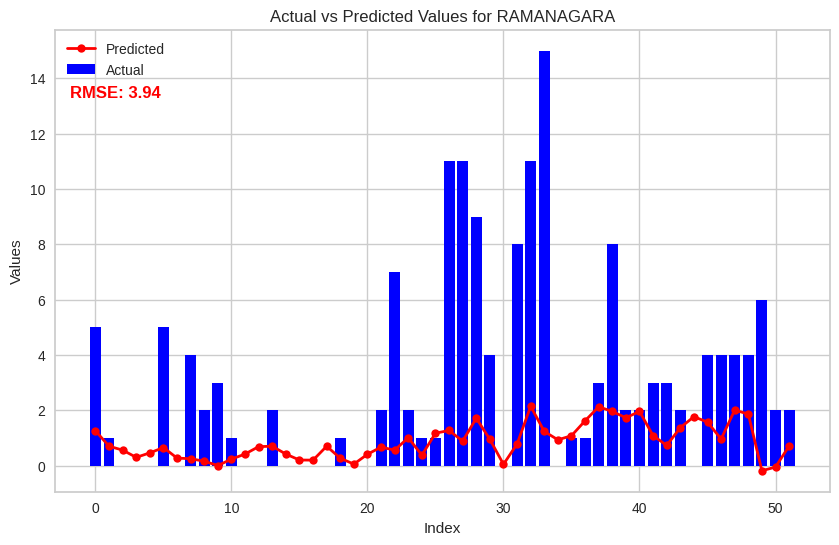

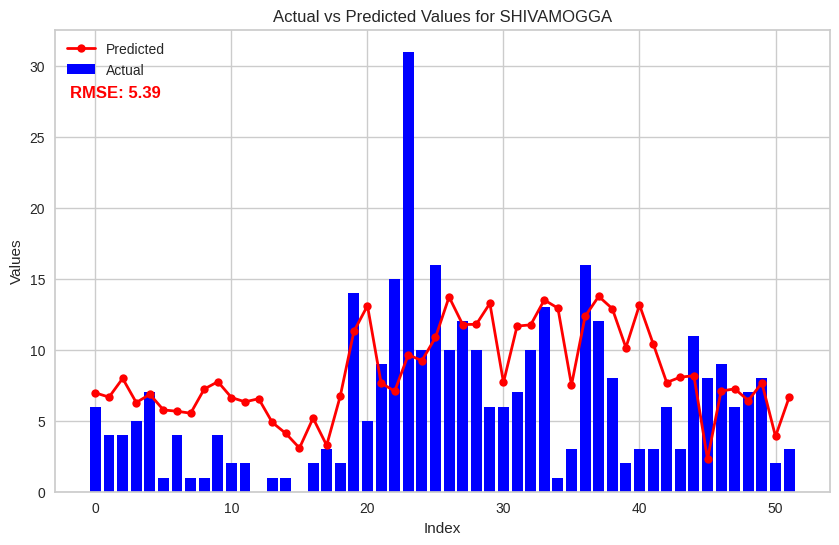

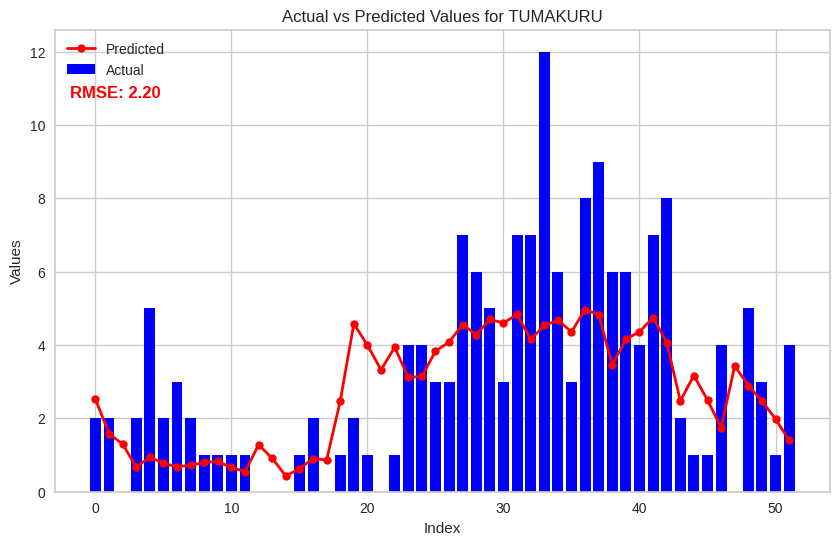

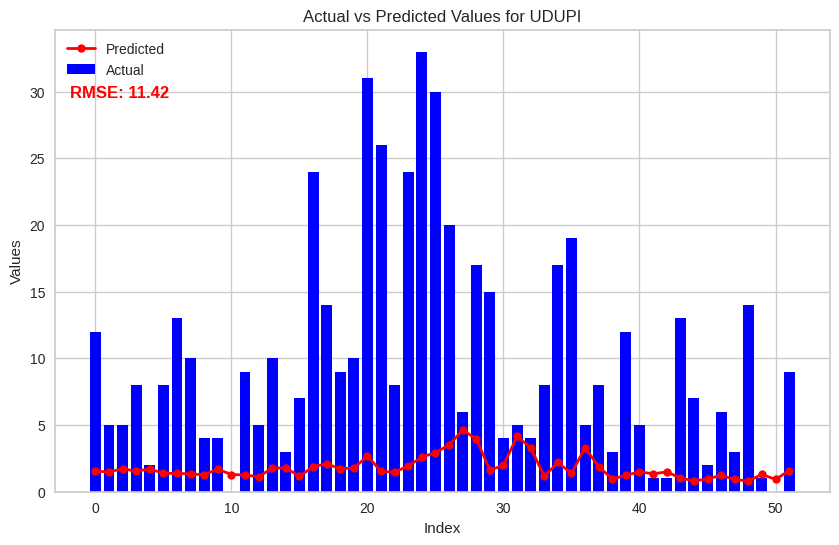

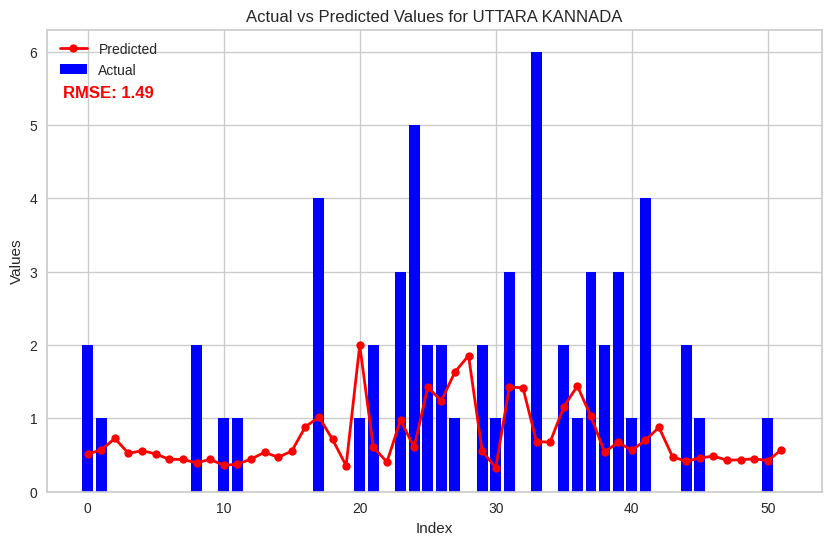

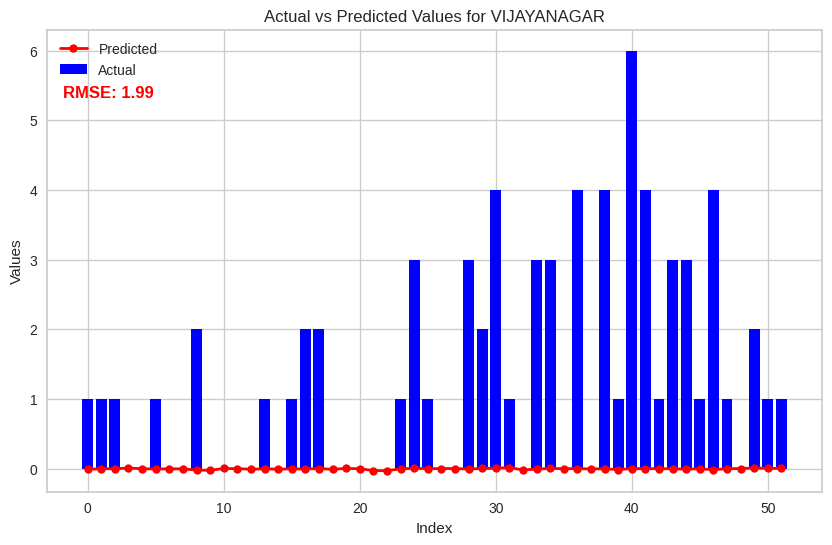

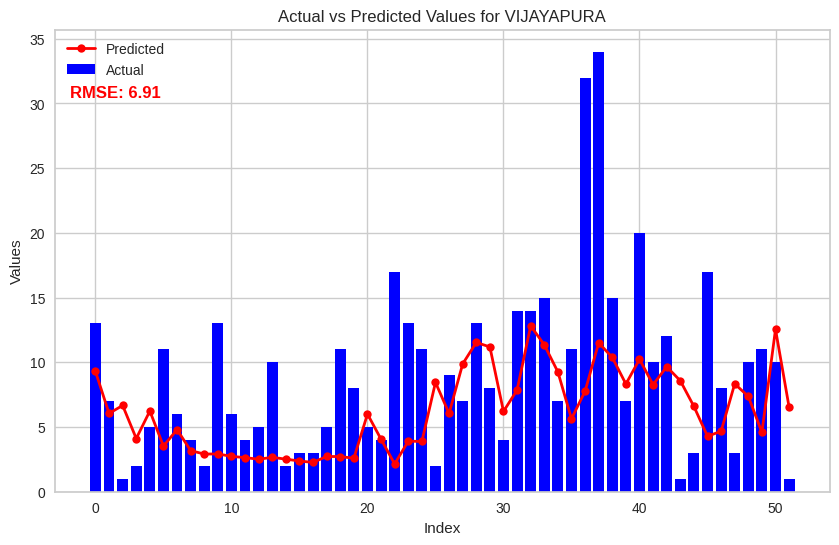

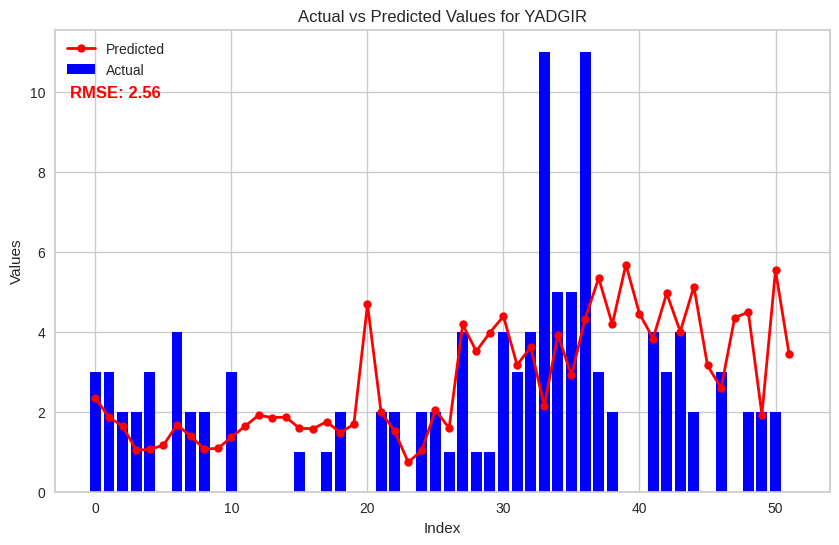

In [28]:
district_analysis_ = DistrictAnalysis_Fine_tuned("Karnataka_weather1980to2022.csv",2022)
df_2022 = district_analysis_.analyze_districts()

In [29]:
from functools import reduce

# List of DataFrames to merge
dfs = [df_2017, df_2018, df_2019, df_2022]

# Function to merge two DataFrames on 'district' with suffixes
def merge_dfs(left, right):
    return pd.merge(left, right, on='district', suffixes=('', f"_{right.columns[-1][-4:]}"))

# Use reduce to iteratively merge all DataFrames
merged_df = reduce(merge_dfs, dfs)

merged_df

district  2017_rmse 2017_performance  2018_rmse 2018_performance  \
0          BAGALKOTE   6.448401              Bad   3.274092              Bad   
1            BALLARI  10.322844              Bad   3.943238              Bad   
2           BELAGAVI   1.454889             Good   1.424813             Good   
3    BENGALURU RURAL   0.535371             Good   0.591329             Good   
4    BENGALURU URBAN   1.016150             Good   0.978202             Good   
5              BIDAR   5.012498              Bad   4.201368              Bad   
6    CHAMARAJANAGARA   2.887520              Bad   2.090487              Bad   
7    CHIKKABALLAPURA   1.668248             Good   1.883204             Good   
8     CHIKKAMAGALURU   6.758749              Bad   2.259165              Bad   
9        CHITRADURGA   9.402908              Bad   5.634401              Bad   
10  DAKSHINA KANNADA   2.735737              Bad  12.960801              Bad   
11         DAVANGERE  20.459911              Bad   4.523972              Bad   
12           DHARWAD   1.768749             Good   2.400106              Bad   
13             GADAG   3.586313              Bad   2.490764              Bad   
14            HASSAN   3.062728              Bad   8.653452              Bad   
15            HAVERI   6.752610              Bad   3.437548              Bad   
16        KALABURAGI  29.153186              Bad  20.815937              Bad   
17            KODAGU   8.754787              Bad   1.807781             Good   
18             KOLAR   8.163542              Bad   3.060145              Bad   
19            KOPPAL   4.023881              Bad   4.143014              Bad   
20            MANDYA   1.769115             Good   1.404110             Good   
21            MYSURU  25.098917              Bad   4.955148              Bad   
22           RAICHUR   3.498099              Bad   1.871736             Good   
23        RAMANAGARA   8.463832              Bad   1.245937             Good   
24        SHIVAMOGGA  10.337173              Bad   5.688998              Bad   
25          TUMAKURU  15.744891              Bad   3.413259              Bad   
26             UDUPI   3.566808              Bad   3.661585              Bad   
27    UTTARA KANNADA   1.127437             Good   2.117567              Bad   
28       VIJAYANAGAR   0.008886             Good   0.003687             Good   
29        VIJAYAPURA   5.181878              Bad   5.635947              Bad   
30            YADGIR   2.431866              Bad   1.587609             Good   

    2019_rmse 2019_performance  2022_rmse 2022_performance  
0    7.413379              Bad   4.825286              Bad  
1    4.319029              Bad   3.257177              Bad  
2    2.439833              Bad   7.317163              Bad  
3    1.316591             Good   2.967181              Bad  
4    3.953994              Bad   1.944287             Good  
5    9.909043              Bad   3.526692              Bad  
6   11.087303              Bad   5.737958              Bad  
7    6.324199              Bad   7.924101              Bad  
8    4.952801              Bad   3.223507              Bad  
9    7.699094              Bad   7.314766              Bad  
10  48.800868              Bad  11.101523              Bad  
11   6.461315              Bad   3.229245              Bad  
12   1.981527             Good   6.379818              Bad  
13   4.248617              Bad   2.437827              Bad  
14   8.191275              Bad   5.707325              Bad  
15   7.169983              Bad   4.127144              Bad  
16   7.243414              Bad   7.817163              Bad  
17   1.708372             Good   1.460182             Good  
18   5.076932              Bad   4.794032              Bad  
19   6.440823              Bad   2.645124              Bad  
20   1.821065             Good   7.916609              Bad  
21   4.145637              Bad  12.154794              Bad  
22   1.409909             Good   1.770407       

In [30]:
merged_df = merged_df.round(2)
merged_df

district  2017_rmse 2017_performance  2018_rmse 2018_performance  \
0          BAGALKOTE       6.45              Bad       3.27              Bad   
1            BALLARI      10.32              Bad       3.94              Bad   
2           BELAGAVI       1.45             Good       1.42             Good   
3    BENGALURU RURAL       0.54             Good       0.59             Good   
4    BENGALURU URBAN       1.02             Good       0.98             Good   
5              BIDAR       5.01              Bad       4.20              Bad   
6    CHAMARAJANAGARA       2.89              Bad       2.09              Bad   
7    CHIKKABALLAPURA       1.67             Good       1.88             Good   
8     CHIKKAMAGALURU       6.76              Bad       2.26              Bad   
9        CHITRADURGA       9.40              Bad       5.63              Bad   
10  DAKSHINA KANNADA       2.74              Bad      12.96              Bad   
11         DAVANGERE      20.46              Bad       4.52              Bad   
12           DHARWAD       1.77             Good       2.40              Bad   
13             GADAG       3.59              Bad       2.49              Bad   
14            HASSAN       3.06              Bad       8.65              Bad   
15            HAVERI       6.75              Bad       3.44              Bad   
16        KALABURAGI      29.15              Bad      20.82              Bad   
17            KODAGU       8.75              Bad       1.81             Good   
18             KOLAR       8.16              Bad       3.06              Bad   
19            KOPPAL       4.02              Bad       4.14              Bad   
20            MANDYA       1.77             Good       1.40             Good   
21            MYSURU      25.10              Bad       4.96              Bad   
22           RAICHUR       3.50              Bad       1.87             Good   
23        RAMANAGARA       8.46              Bad       1.25             Good   
24        SHIVAMOGGA      10.34              Bad       5.69              Bad   
25          TUMAKURU      15.74              Bad       3.41              Bad   
26             UDUPI       3.57              Bad       3.66              Bad   
27    UTTARA KANNADA       1.13             Good       2.12              Bad   
28       VIJAYANAGAR       0.01             Good       0.00             Good   
29        VIJAYAPURA       5.18              Bad       5.64              Bad   
30            YADGIR       2.43              Bad       1.59             Good   

    2019_rmse 2019_performance  2022_rmse 2022_performance  
0        7.41              Bad       4.83              Bad  
1        4.32              Bad       3.26              Bad  
2        2.44              Bad       7.32              Bad  
3        1.32             Good       2.97              Bad  
4        3.95              Bad       1.94             Good  
5        9.91              Bad       3.53              Bad  
6       11.09              Bad       5.74              Bad  
7        6.32              Bad       7.92              Bad  
8        4.95              Bad       3.22              Bad  
9        7.70              Bad       7.31              Bad  
10      48.80              Bad      11.10              Bad  
11       6.46              Bad       3.23              Bad  
12       1.98             Good       6.38              Bad  
13       4.25              Bad       2.44              Bad  
14       8.19              Bad       5.71              Bad  
15       7.17              Bad       4.13              Bad  
16       7.24              Bad       7.82              Bad  
17       1.71             Good       1.46             Good  
18       5.08              Bad       4.79              Bad  
19       6.44              Bad       2.65              Bad  
20       1.82             Good       7.92              Bad  
21       4.15              Bad      12.15              Bad  
22       1.41             Good       1.77       

In [31]:
merged_df.to_csv('neural_networks_performance.csv', index=False)

In [32]:
df = pd.read_csv("neural_networks_performance.csv")
df

district  2017_rmse 2017_performance  2018_rmse 2018_performance  \
0          BAGALKOTE       6.45              Bad       3.27              Bad   
1            BALLARI      10.32              Bad       3.94              Bad   
2           BELAGAVI       1.45             Good       1.42             Good   
3    BENGALURU RURAL       0.54             Good       0.59             Good   
4    BENGALURU URBAN       1.02             Good       0.98             Good   
5              BIDAR       5.01              Bad       4.20              Bad   
6    CHAMARAJANAGARA       2.89              Bad       2.09              Bad   
7    CHIKKABALLAPURA       1.67             Good       1.88             Good   
8     CHIKKAMAGALURU       6.76              Bad       2.26              Bad   
9        CHITRADURGA       9.40              Bad       5.63              Bad   
10  DAKSHINA KANNADA       2.74              Bad      12.96              Bad   
11         DAVANGERE      20.46              Bad       4.52              Bad   
12           DHARWAD       1.77             Good       2.40              Bad   
13             GADAG       3.59              Bad       2.49              Bad   
14            HASSAN       3.06              Bad       8.65              Bad   
15            HAVERI       6.75              Bad       3.44              Bad   
16        KALABURAGI      29.15              Bad      20.82              Bad   
17            KODAGU       8.75              Bad       1.81             Good   
18             KOLAR       8.16              Bad       3.06              Bad   
19            KOPPAL       4.02              Bad       4.14              Bad   
20            MANDYA       1.77             Good       1.40             Good   
21            MYSURU      25.10              Bad       4.96              Bad   
22           RAICHUR       3.50              Bad       1.87             Good   
23        RAMANAGARA       8.46              Bad       1.25             Good   
24        SHIVAMOGGA      10.34              Bad       5.69              Bad   
25          TUMAKURU      15.74              Bad       3.41              Bad   
26             UDUPI       3.57              Bad       3.66              Bad   
27    UTTARA KANNADA       1.13             Good       2.12              Bad   
28       VIJAYANAGAR       0.01             Good       0.00             Good   
29        VIJAYAPURA       5.18              Bad       5.64              Bad   
30            YADGIR       2.43              Bad       1.59             Good   

    2019_rmse 2019_performance  2022_rmse 2022_performance  
0        7.41              Bad       4.83              Bad  
1        4.32              Bad       3.26              Bad  
2        2.44              Bad       7.32              Bad  
3        1.32             Good       2.97              Bad  
4        3.95              Bad       1.94             Good  
5        9.91              Bad       3.53              Bad  
6       11.09              Bad       5.74              Bad  
7        6.32              Bad       7.92              Bad  
8        4.95              Bad       3.22              Bad  
9        7.70              Bad       7.31              Bad  
10      48.80              Bad      11.10              Bad  
11       6.46              Bad       3.23              Bad  
12       1.98             Good       6.38              Bad  
13       4.25              Bad       2.44              Bad  
14       8.19              Bad       5.71              Bad  
15       7.17              Bad       4.13              Bad  
16       7.24              Bad       7.82              Bad  
17       1.71             Good       1.46             Good  
18       5.08              Bad       4.79              Bad  
19       6.44              Bad       2.65              Bad  
20       1.82             Good       7.92              Bad  
21       4.15              Bad      12.15              Bad  
22       1.41             Good       1.77       